# for bjorkeny estimation

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor as RFR
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import randint
import matplotlib.pyplot as plt
# import seaborn as sns

from collections import Counter
# import os
from sklearn import preprocessing
from sklearn.decomposition import PCA
from functions import *
import keras
import pickle


2024-07-24 09:52:20.934162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 09:52:22.077020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Newest Data


In [2]:
X_full = None
y_full = None
df = None
df = load_data("/home/jbosman/datav7.2_flux_weighed_reduced/", "neutrino")

energy_crit = 20
z_dir_crit = 0
df = df[(df["pdgid"]==14)&(df["is_cc"]==1)]
mask_z_dir = df['E.trks.dir.z[.,0]'] > 0
mask_energy = (df["E.trks.E[.,0]"] <= energy_crit) | (df["E.trks.E[.,1]"] <= energy_crit)
mask = mask_z_dir & mask_energy

df = df[mask]
# df = df[df["energy"]<=20]
# df = df[np.invert((df['closest[.,0,0]']==1e20) | (df['closest[.,0,1]']==1e20) | (df['closest[.,0,2]']==1e20) | (df['closest[.,1,0]']==1e20) | (df['closest[.,1,1]']==1e20) | (df['closest[.,1,2]']==1e20)  )] 
# x_min = df["E.trks.pos.x[.,0]"].min()
# x_max = df["E.trks.pos.x[.,0]"].max()
# y_min = df["E.trks.pos.y[.,0]"].min()
# y_max = df["E.trks.pos.y[.,0]"].max()
# z_min = df["E.trks.pos.z[.,0]"].min()
# z_max = df["E.trks.pos.z[.,0]"].max()
# height = z_max-z_min
# radius = np.sqrt(((x_max-x_min)/2)**2+((y_max-y_min)/2)**2)
# radius_crit = 0.5
# z_pos_crit = 0.1
# df = df[(df["E.trks.pos.x[.,0]"]>x_min+radius_crit*radius) & (df["E.trks.pos.x[.,0]"]<x_max-radius_crit*radius) & (df["E.trks.pos.y[.,0]"]>y_min+radius_crit*radius) & (df["E.trks.pos.y[.,0]"]<y_max-radius_crit*radius) & (df["E.trks.pos.z[.,0]"]>z_min+height*z_pos_crit) & (df["E.trks.pos.z[.,0]"]<z_max-height*z_pos_crit)&(df["E.trks.pos.z[.,1]"]>z_min+height*z_pos_crit) & (df["E.trks.pos.z[.,1]"]<z_max-height*z_pos_crit)]


plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["figure.labelsize"] = 14
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 12


In [3]:
print(df["is_neutrino"].value_counts())
print(df["pdgid"].value_counts())

simulation_columns = ['E.mc_trks.dir.z[.,0]', 'E.mc_trks.pos.x[.,0]', 'E.mc_trks.pos.y[.,0]', 'E.mc_trks.pos.z[.,0]', 'T.sum_mc_evt.livetime_DAQ', 
                      'T.sum_mc_evt.weight', 'T.sum_mc_evt.weight_noOsc', 'T.sum_mc_nu.by', 'is_neutrino', 'exposure', 'weight_one_year', 'flux_weight', 
                      'E.frame_index', 'energy', 'pdgid', 'E.run_id', 'E.trigger_counter', 'E.trigger_mask', 'weight_rate', 'w2', 'ngen', 'cos_zenith_true'
                      ,"E_min_gen", "is_cc"]
y_full = df[simulation_columns]
X_full = df.drop(columns = simulation_columns)



is_neutrino
1.0    57998
Name: count, dtype: int64
pdgid
14    57998
Name: count, dtype: int64


## plots per quartile

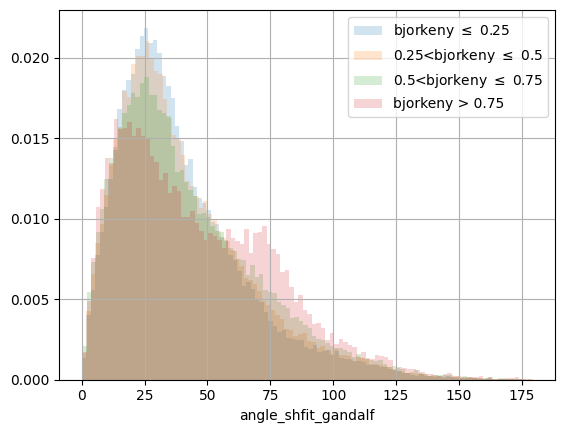

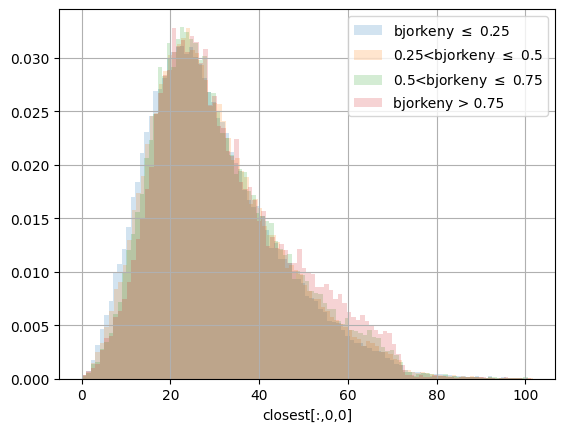

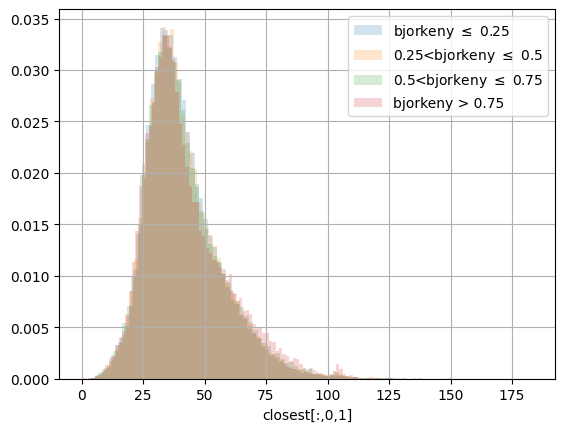

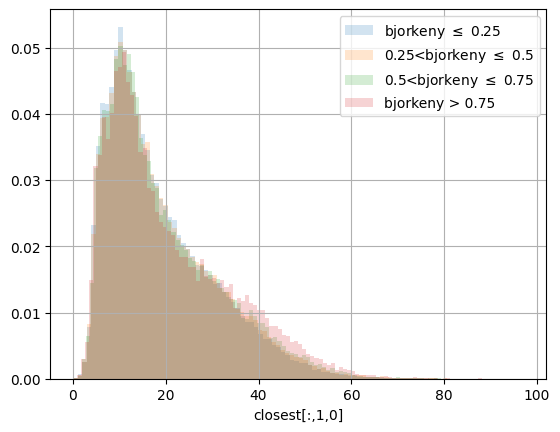

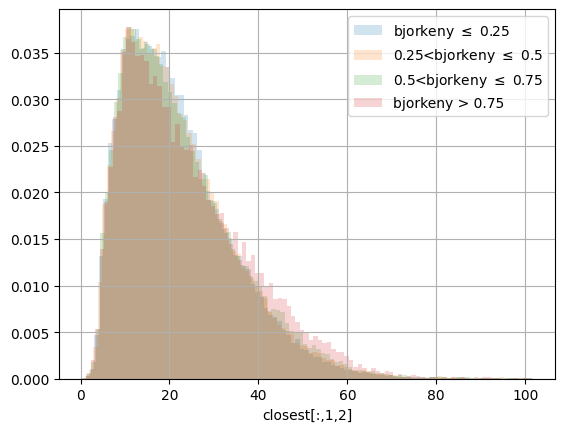

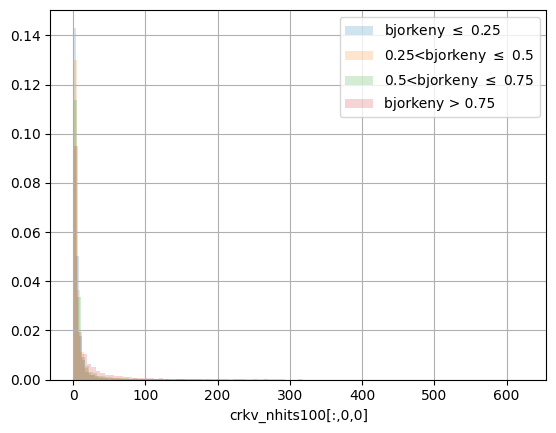

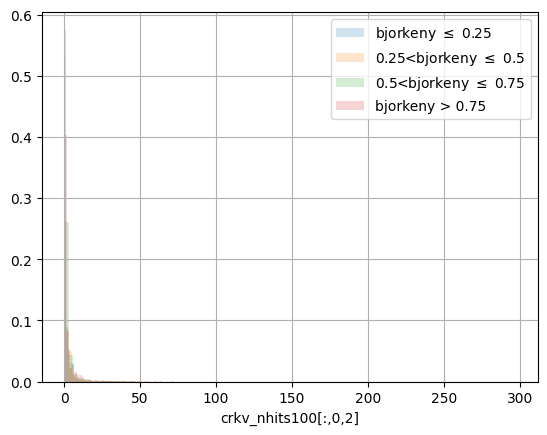

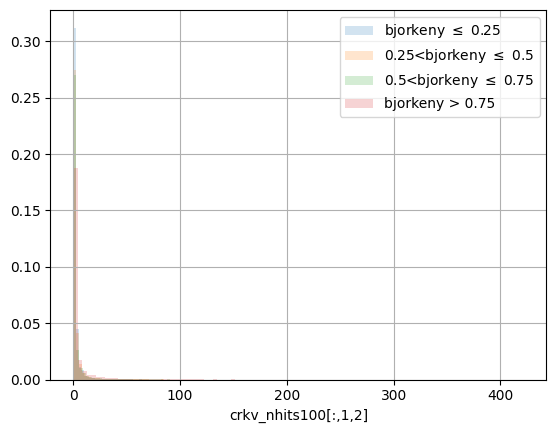

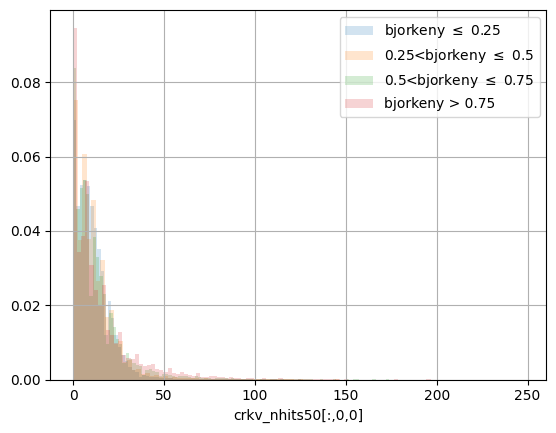

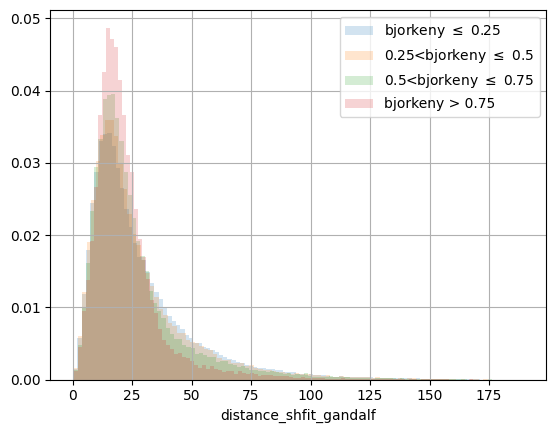

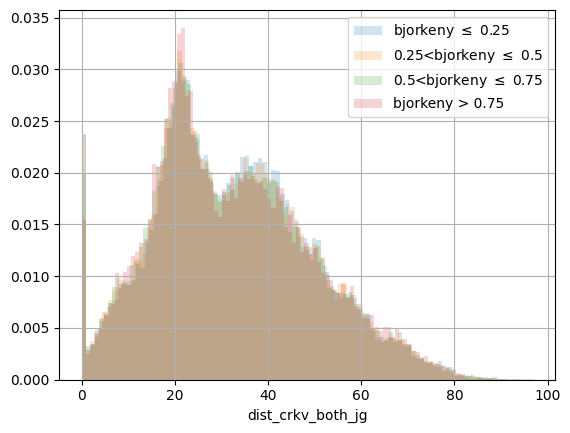

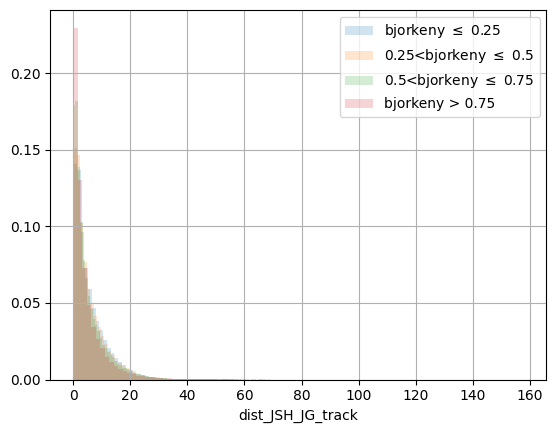

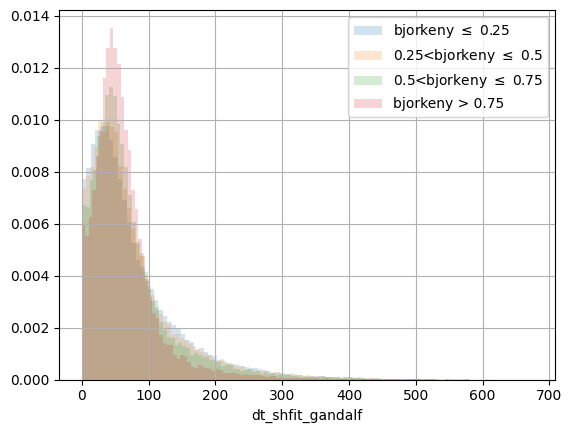

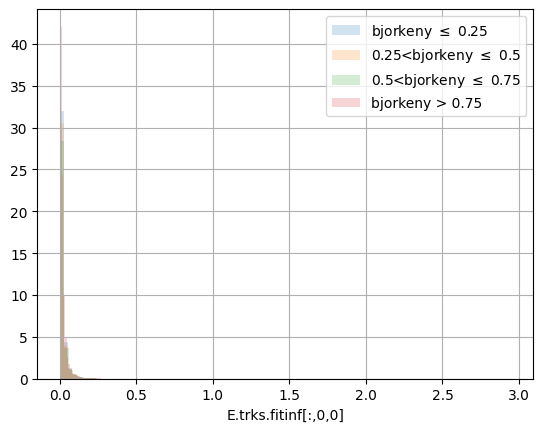

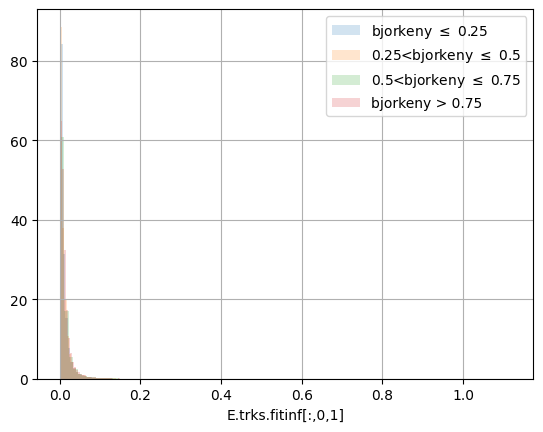

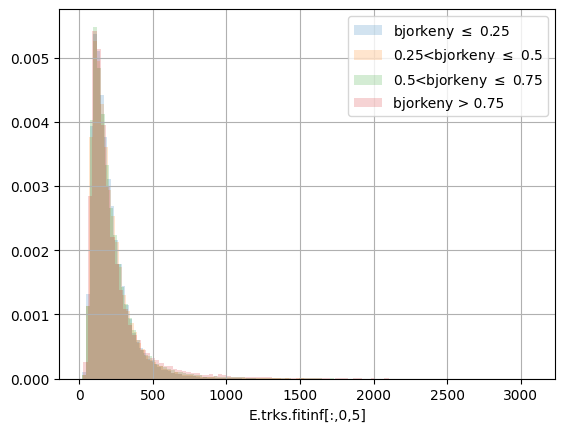

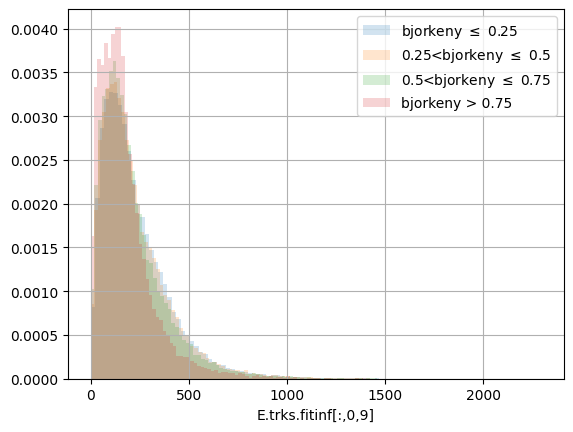

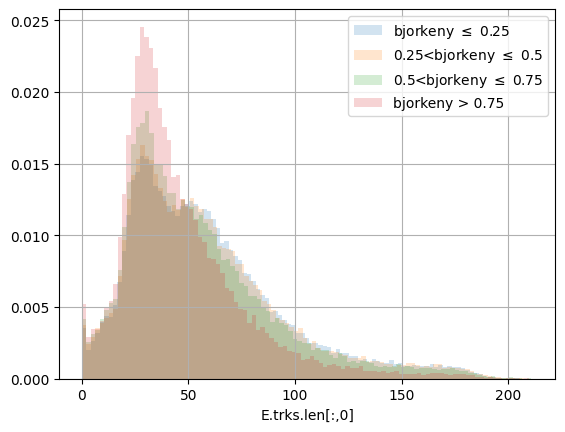

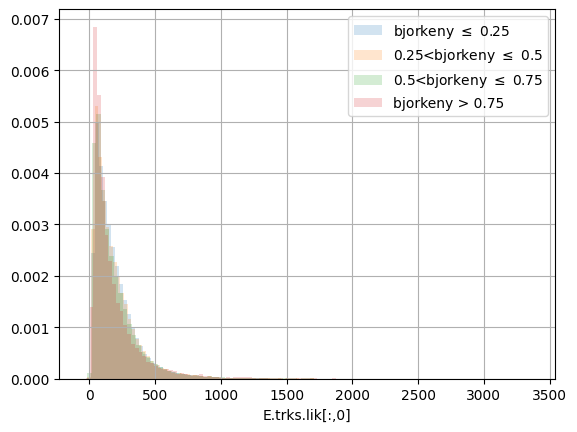

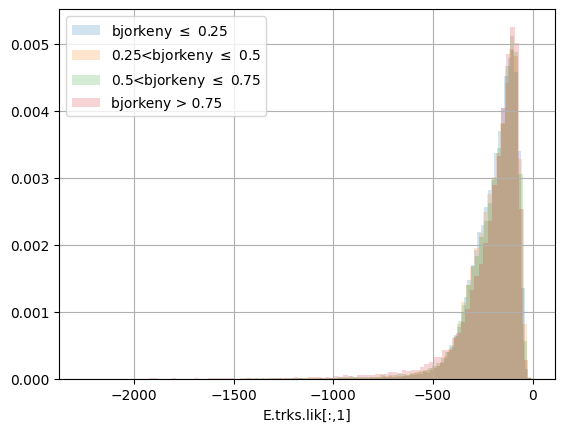

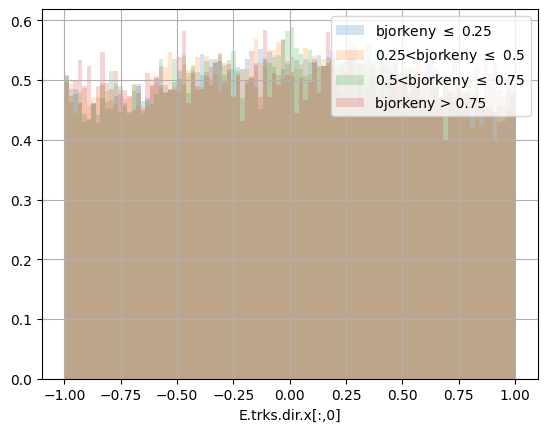

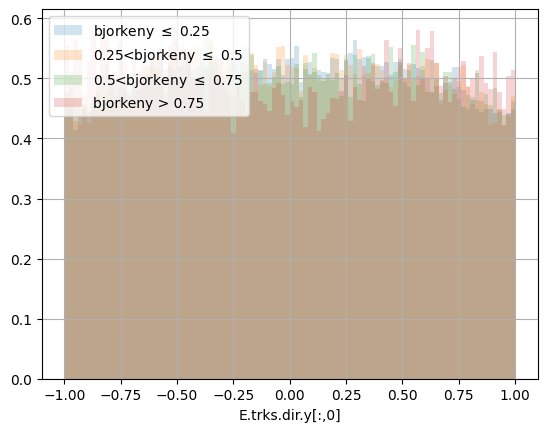

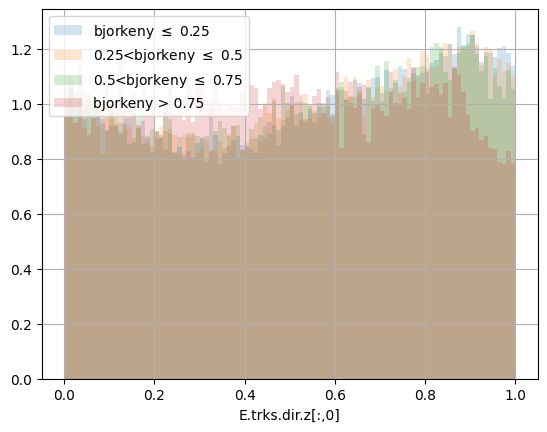

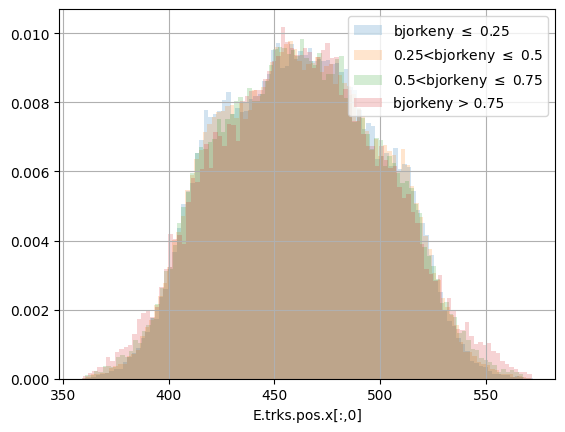

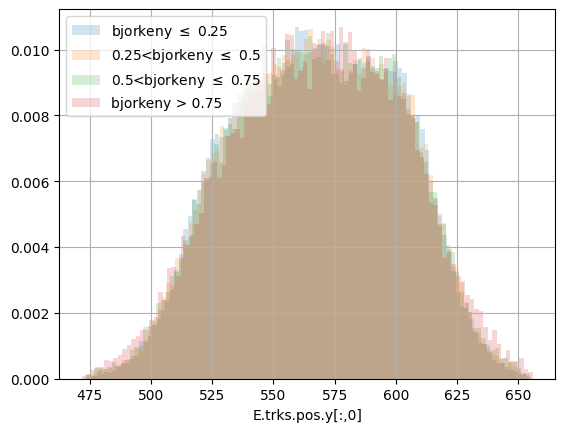

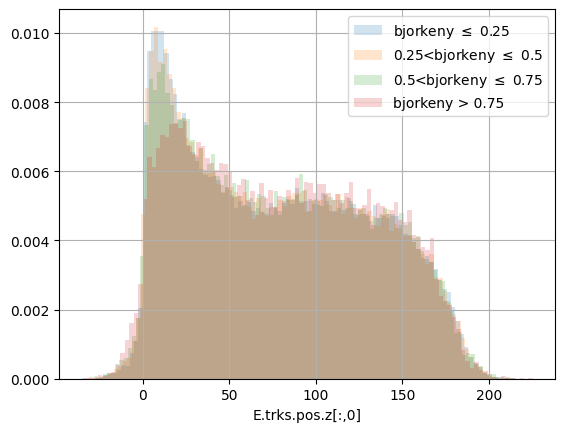

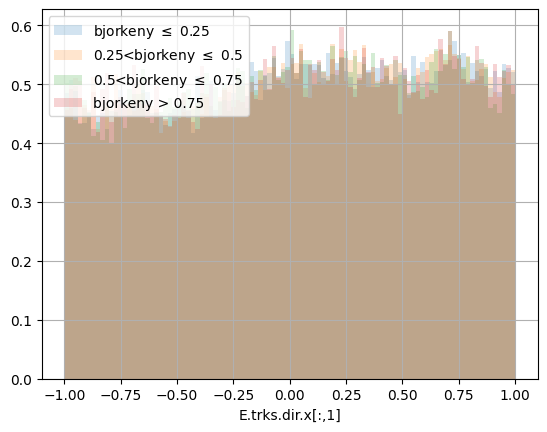

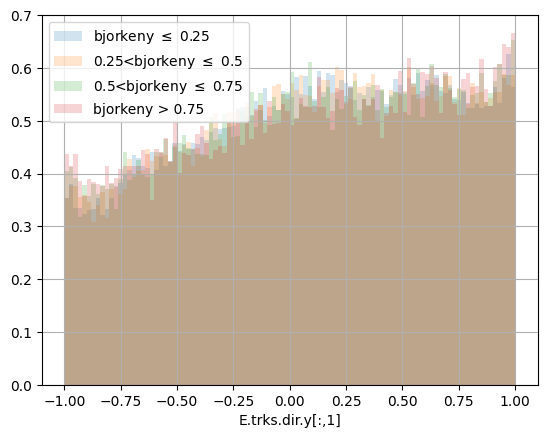

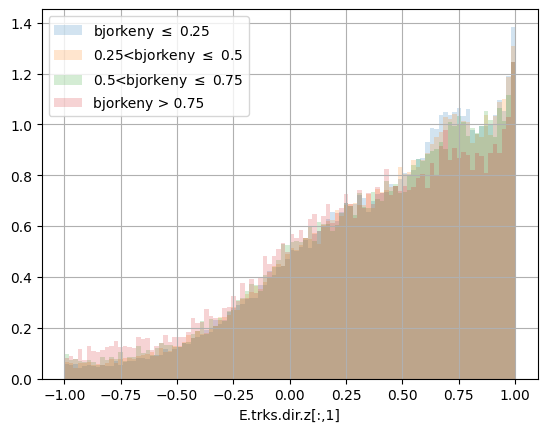

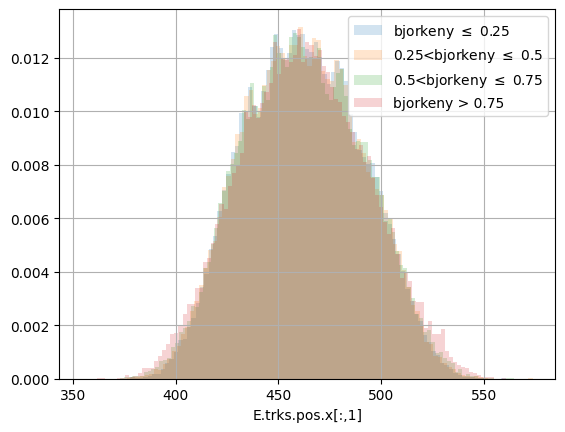

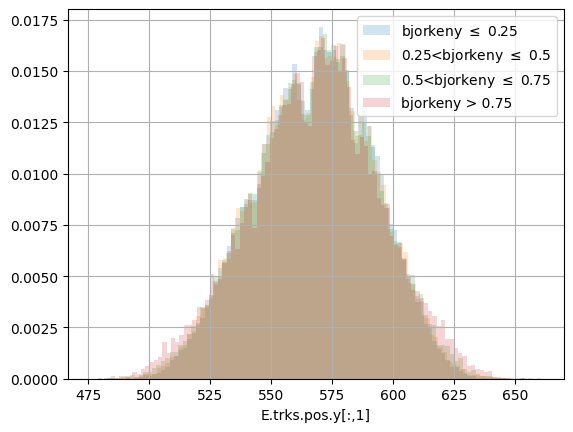

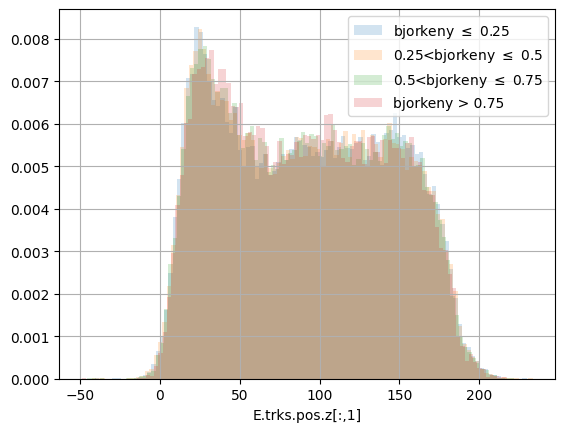

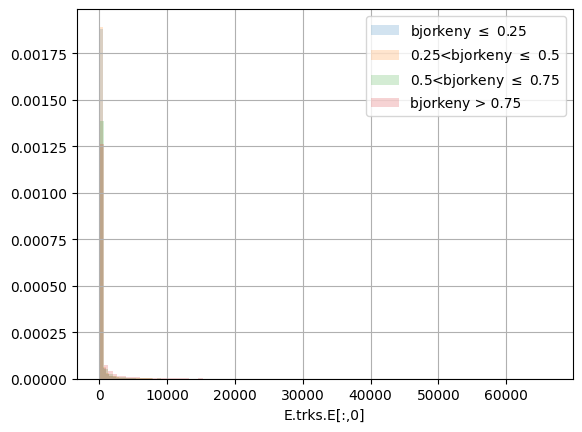

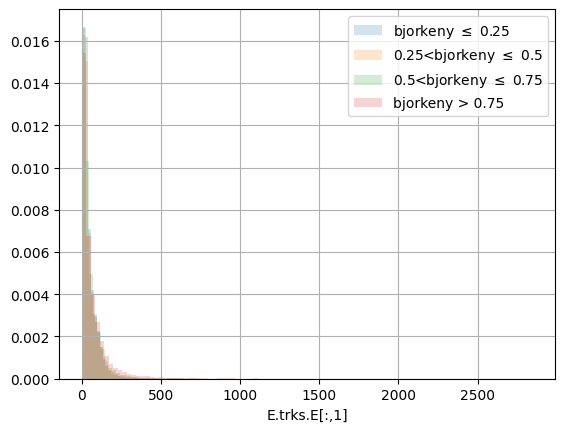

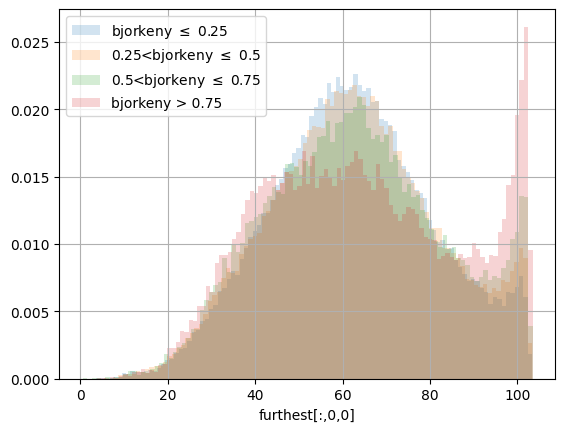

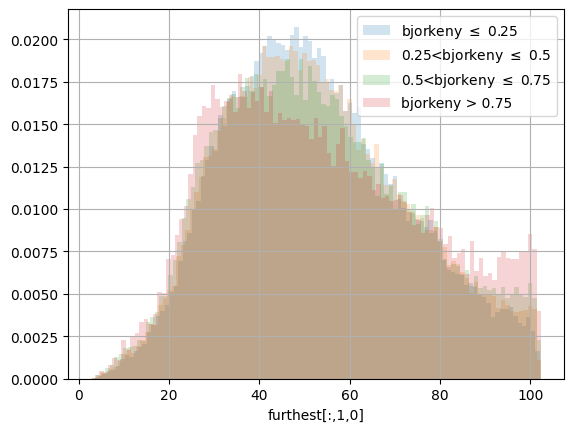

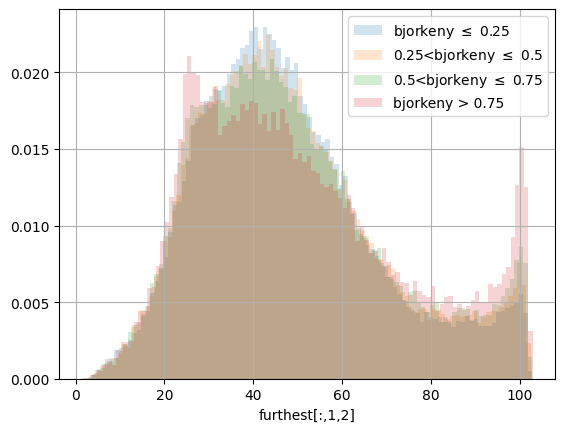

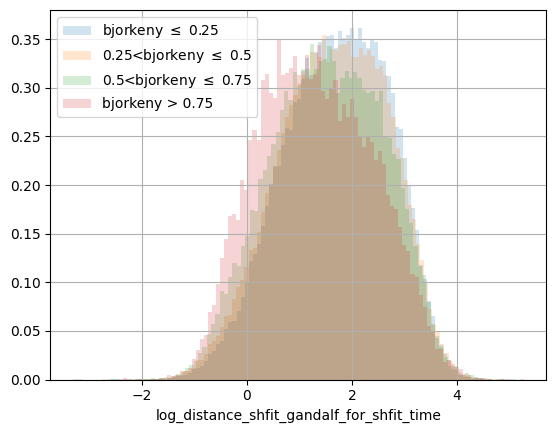

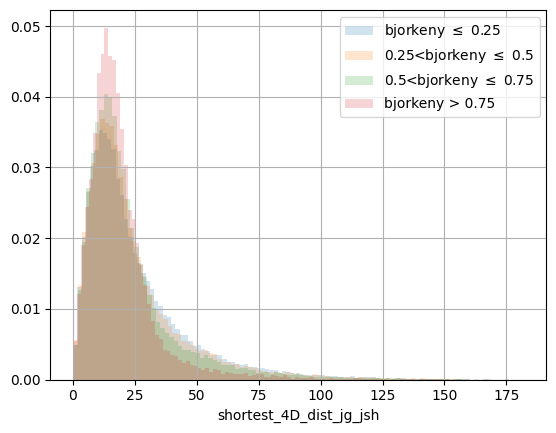

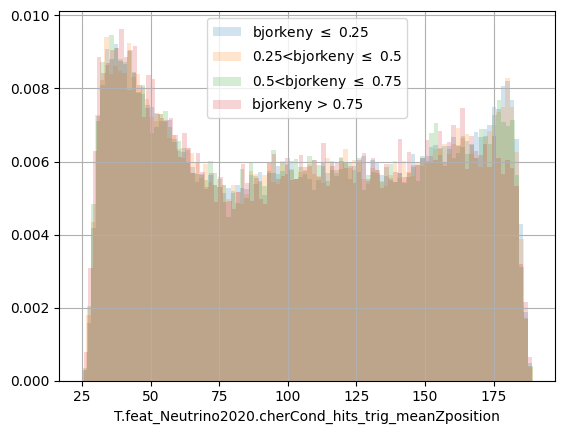

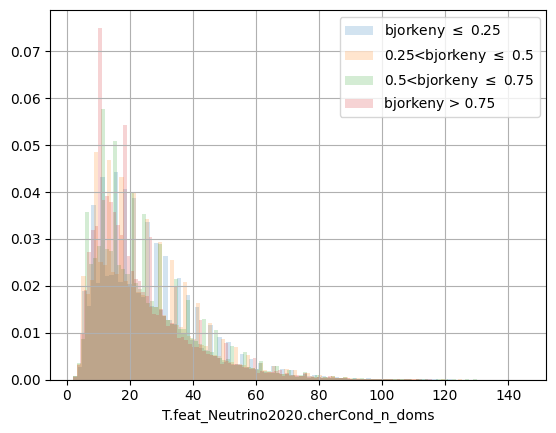

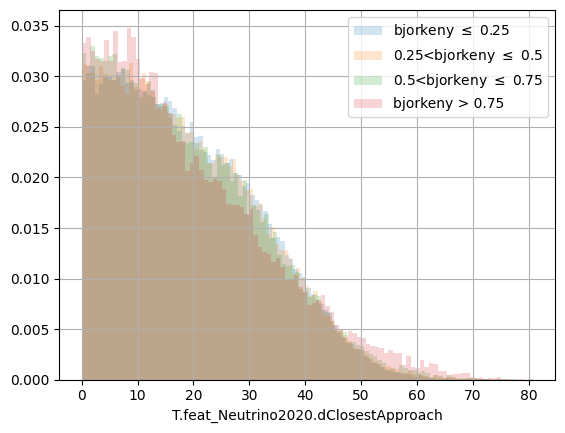

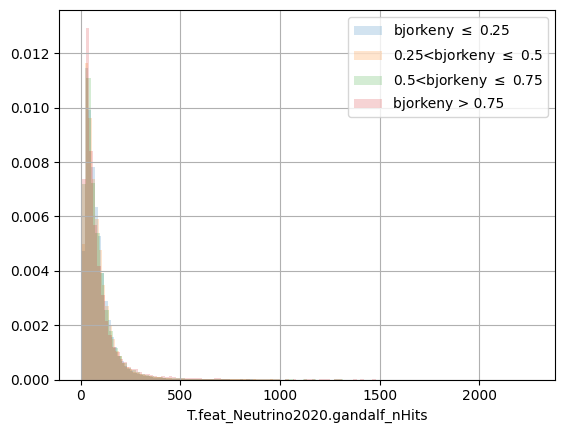

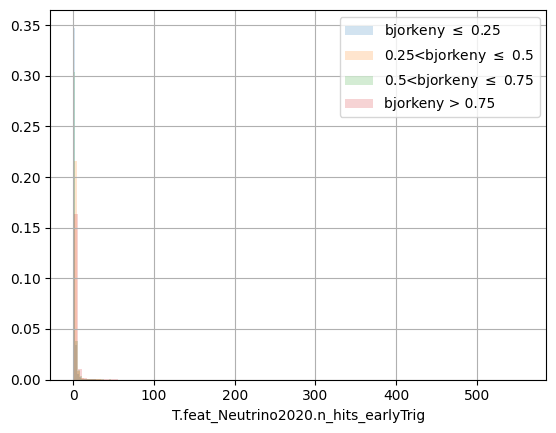

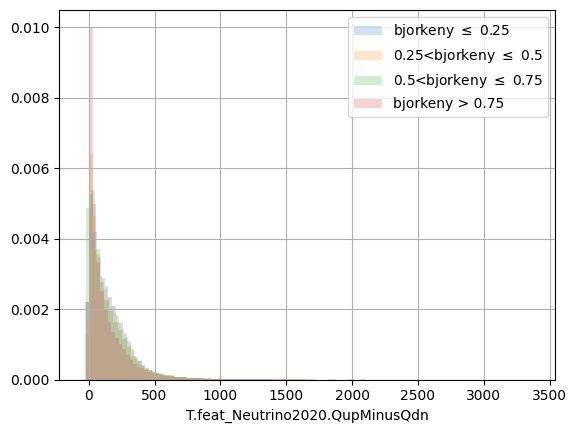

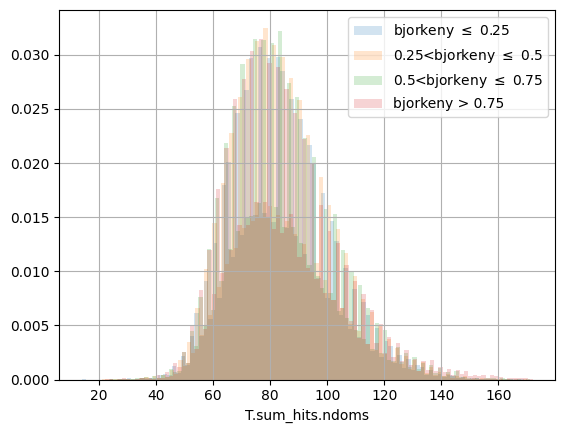

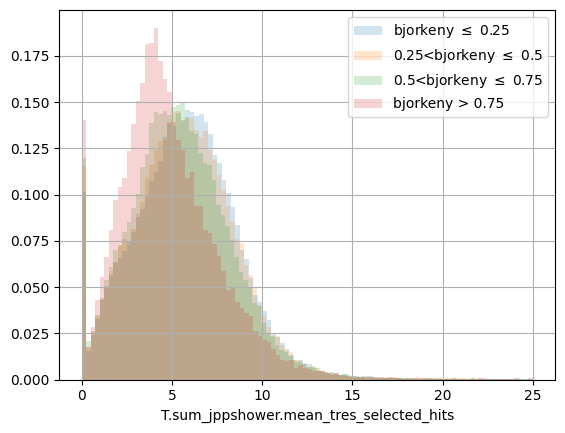

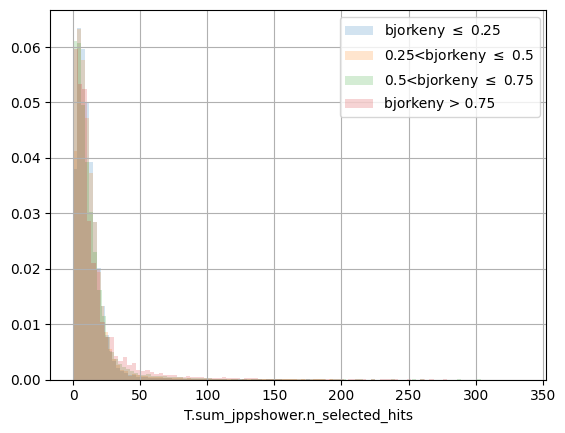

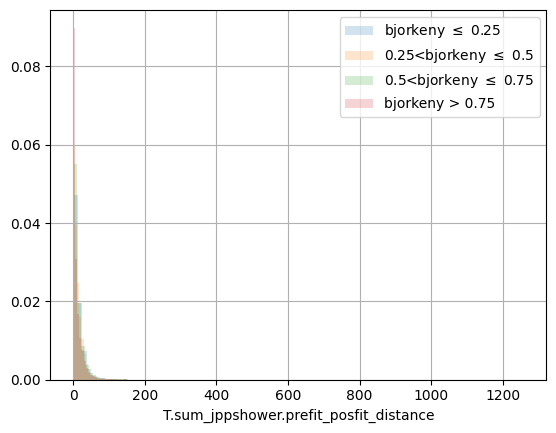

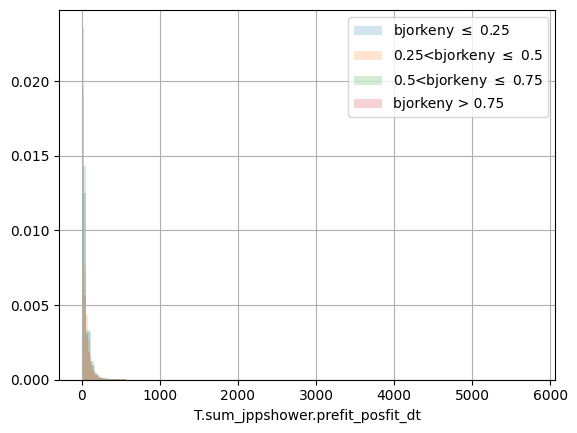

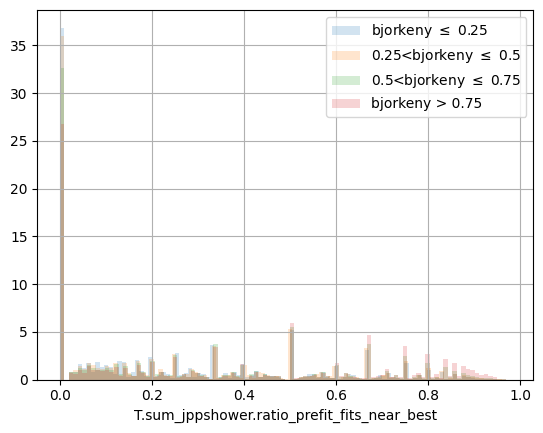

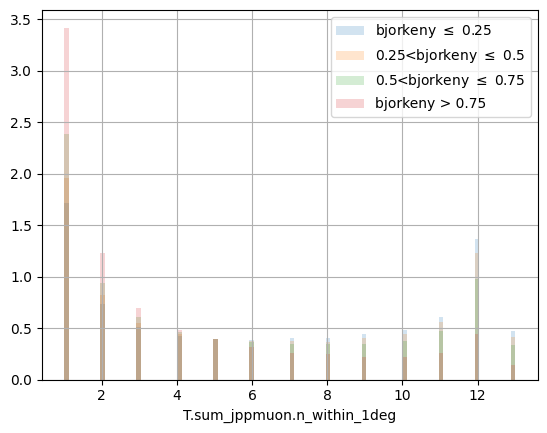

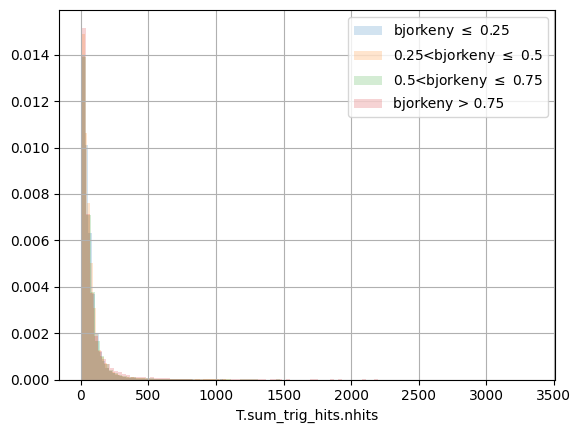

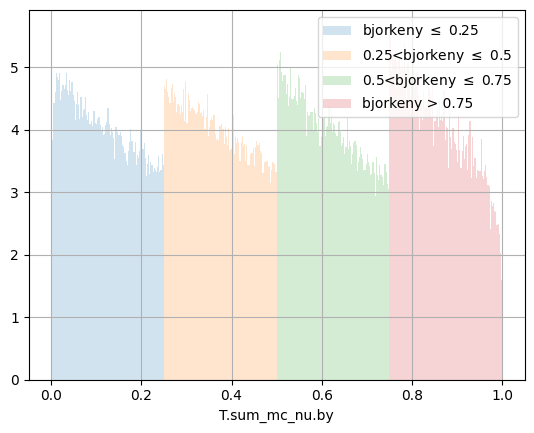

In [216]:
alpha = 0.2
for column in df.columns:
    hist1 = df[df["T.sum_mc_nu.by"]<= 0.25][column].hist(bins = 100, alpha = alpha, label = "bjorkeny $\leq$ 0.25", density = True)
    hist2 = df[(df["T.sum_mc_nu.by"]> 0.25)& (df["T.sum_mc_nu.by"]<= 0.5)][column].hist(bins = 100, alpha = alpha, label = "0.25<bjorkeny $\leq$ 0.5", density = True)
    hist3 = df[(df["T.sum_mc_nu.by"]> 0.5)& (df["T.sum_mc_nu.by"]<= 0.75)][column].hist(bins = 100, alpha = alpha, label = "0.5<bjorkeny $\leq$ 0.75", density = True)
    hist4 = df[(df["T.sum_mc_nu.by"]> 0.75)][column].hist(bins = 100, alpha = alpha, label = "bjorkeny > 0.75", density = True)
    plt.xlabel(column)
    plt.legend()
    plt.show()

## optimize for correlation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


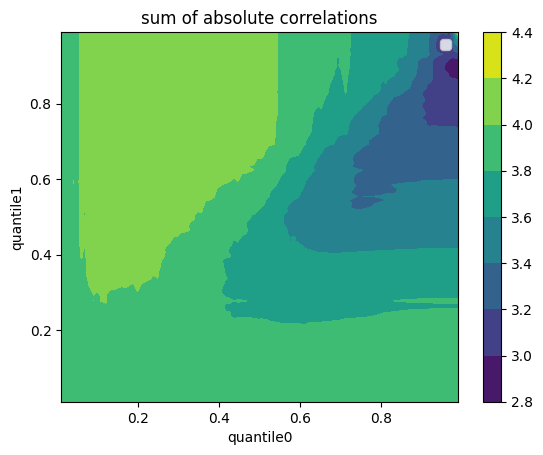

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(100, 100)
(100, 100)


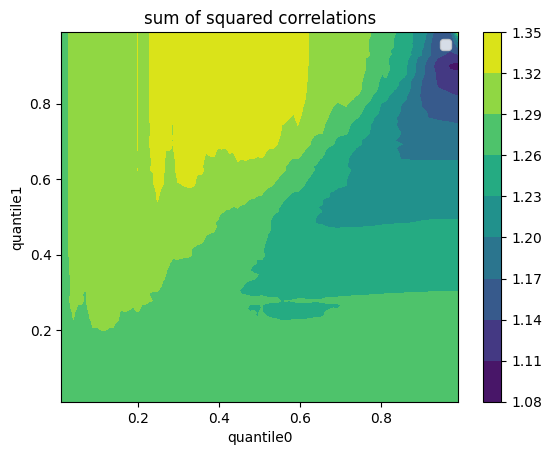

In [32]:
df_test = df
# # df_test = df_test[np.invert((df_test['closest[.,0,0]']==1e20) | (df_test['closest[.,1,0]']==1e20) | (df_test['closest[.,1,2]']==1e20) | (df_test['closest[.,0,1]']==1e20)  )] 
quantiles_0 = np.linspace(0.01, 0.99, 100)
quantiles_1 = np.linspace(0.01, 0.99, 100)
tot_abs_cors = []
tot_sq_cors = []
for quantile_0 in quantiles_0:
        for quantile_1 in quantiles_1:

            df_corr = df_test[(df_test["E.trks.lik[.,0]"]>np.quantile(df_test["E.trks.lik[.,0]"], quantile_0)) | (df_test["E.trks.lik[.,1]"] < np.quantile(df_test["E.trks.lik[.,1]"], 1-quantile_1))]
            corr = df_corr.corr()
            bjorkeny_corr = corr['T.sum_mc_nu.by']
            tot_abs_cors.append(abs(bjorkeny_corr).sum())
            tot_sq_cors.append((bjorkeny_corr**2).sum())


X, Y = np.meshgrid(quantiles_0, quantiles_1)
plt.contourf(X, Y, np.array(tot_abs_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of absolute correlations")
plt.show()


print(X.shape)
print(Y.shape)
plt.contourf(X, Y, np.array(tot_sq_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of squared correlations")
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


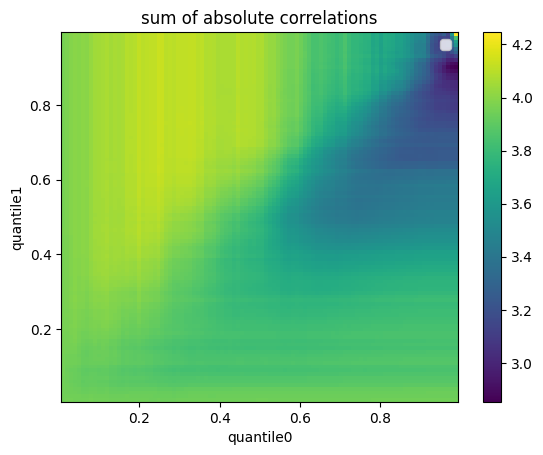

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


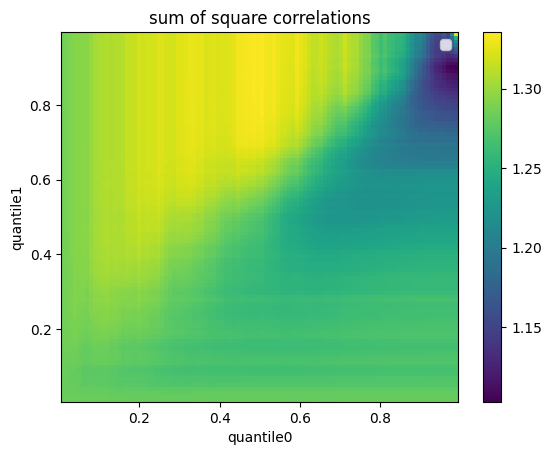

In [34]:
plt.pcolormesh(X, Y, np.array(tot_abs_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of absolute correlations")
plt.show()

plt.pcolormesh(X, Y, np.array(tot_sq_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of square correlations")
plt.show()

In [9]:
quantile_0 = 0.1
quantile_1 = 0.2
rel_threshold = 0
df_selec = df_test[(df_test["E.trks.lik[.,0]"]>np.quantile(df_test["E.trks.lik[.,0]"], quantile_0)) | (df_test["E.trks.lik[.,1]"] < np.quantile(df_test["E.trks.lik[.,1]"], 1-quantile_1))]

print(df_selec.info())
corr = correlation_matrix(df_selec, figsize = (30,30), plot = True)
# corr = df_selec.corr()
bjorkeny_corr = corr['T.sum_mc_nu.by']

print("total correlation = ", abs(bjorkeny_corr).sum())
print("total squared correlations = ", (bjorkeny_corr**2).sum())
# bjorkeny_corr = bjorkeny_corr[bjorkeny_corr!=0]
# bjorkeny_corr = bjorkeny_corr[b]
# bjorkeny_corr = bjorkeny_corr.sort_values(ascending = False)

non_rel = bjorkeny_corr.index[abs(bjorkeny_corr)<=rel_threshold]


print(len(df_selec))
X = df_selec.drop(columns = non_rel)
bjorkeny = X["T.sum_mc_nu.by"]
X = X.drop(columns = "T.sum_mc_nu.by")


NameError: name 'df_test' is not defined

# Try RFRregression for idea about feature importance and baseline

In [7]:
random_state = 42

bjorkeny = y_full["T.sum_mc_nu.by"].values

# Scale the data
X = X_full.values
# scaler = preprocessing.RobustScaler()
# X = scaler.fit_transform(X)

# # PCA
# n_components_PCA = 0.9

# pca = PCA(n_components=n_components_PCA, svd_solver="full")
# X = pca.fit_transform(X)

# Split the data into folds
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

scores = []

y_pred_total = []
y_test_total = []

importances = np.zeros(len(X_full.columns))

for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = bjorkeny[train_index], bjorkeny[test_index]

    regr = RFR(random_state = random_state, n_jobs = -1)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    score = regr.score(X_test, y_test)
    scores.append(score)
    y_pred_total.extend(y_pred)
    y_test_total.extend(y_test)
    importances += regr.feature_importances_

importances = importances/5

print(np.mean(scores))

y_pred_total = np.array(y_pred_total).reshape(-1,1)
y_test_total = np.array(y_test_total).reshape(-1,1)

0.2101426455788425


Feature ranking:
1. feature T.feat_Neutrino2020.QupOvernHits (0.053888)
2. feature T.sum_jppshower.prefit_posfit_distance (0.052629)
3. feature T.sum_jpptrack.n_within_1deg (0.022706)
4. feature crkv_nhits50[.,0,0] (0.020625)
5. feature sumtot[.,0,0] (0.018342)
6. feature ratio_both_tot_jg (0.018210)
7. feature angle_shfit_gandalf (0.017570)
8. feature gandalf_shfit_lik_ratio (0.015729)
9. feature T.sum_jppshower.ratio_prefit_fits_near_best (0.014983)
10. feature T.sum_jppshower.mean_tres_selected_hits (0.014850)
11. feature dt_shfit_gandalf (0.014295)
12. feature E.trks.fitinf[.,0,9] (0.014082)
13. feature ratio_both_tot_jsh (0.013130)
14. feature T.feat_Neutrino2020.dClosestApproach (0.013020)
15. feature closest[.,0,0] (0.012841)
16. feature ratio_E_jshf_gandalf (0.012565)
17. feature T.sum_jppshower.prefit_posfit_dt (0.012558)
18. feature E.trks.fitinf[.,0,5] (0.012508)
19. feature closest[.,1,2] (0.012226)
20. feature E.trks.dir.y[.,1] (0.012176)
21. feature dist_crkv_both_jg (0.0

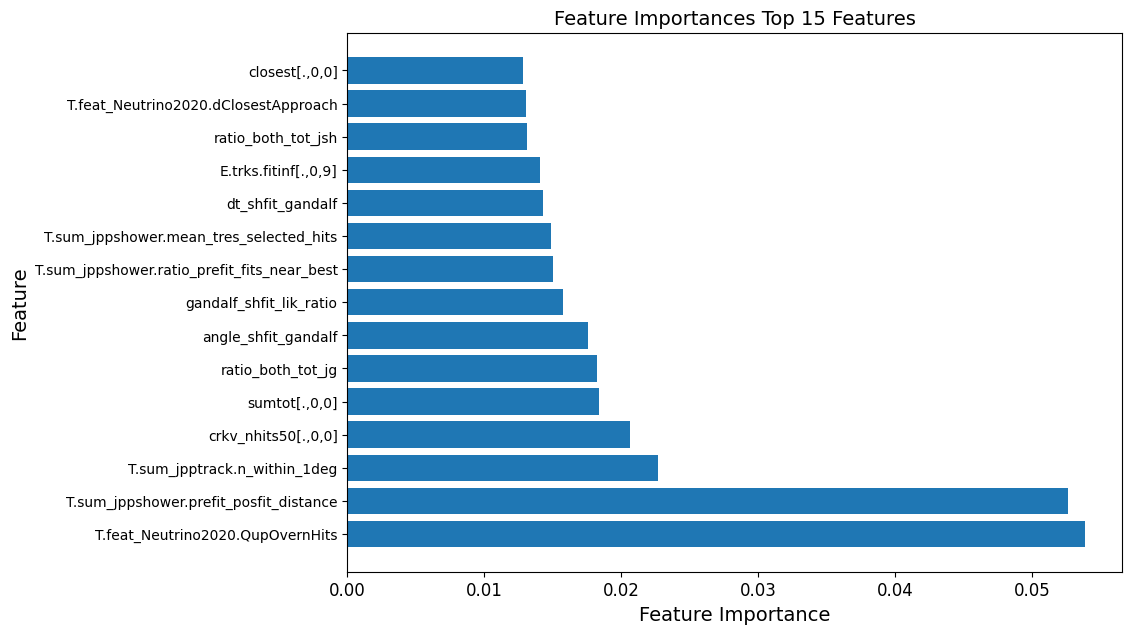

In [8]:
n_features = 15
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_full.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_full.columns[indices[f]], importances[indices[f]]))
# Get feature importances from the RandomForestClassifier


# Get column names from X_train
column_names = X_full.columns
# Rearrange column names based on sorted feature importances
sorted_column_names = column_names[indices[:n_features]]
sorted_importances = importances[indices[:n_features]]

# Create a bar plot
plt.figure(figsize=(10, 7))
plt.barh(range(n_features), sorted_importances)
plt.yticks(range(n_features), sorted_column_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Top {} Features'.format(n_features))
plt.show()


In [9]:
y_pred_total = np.ravel(y_pred_total)
y_test_total = np.ravel(y_test_total)

0.2101426455788425 0.005071871243630746
(57998,)
(57998,)


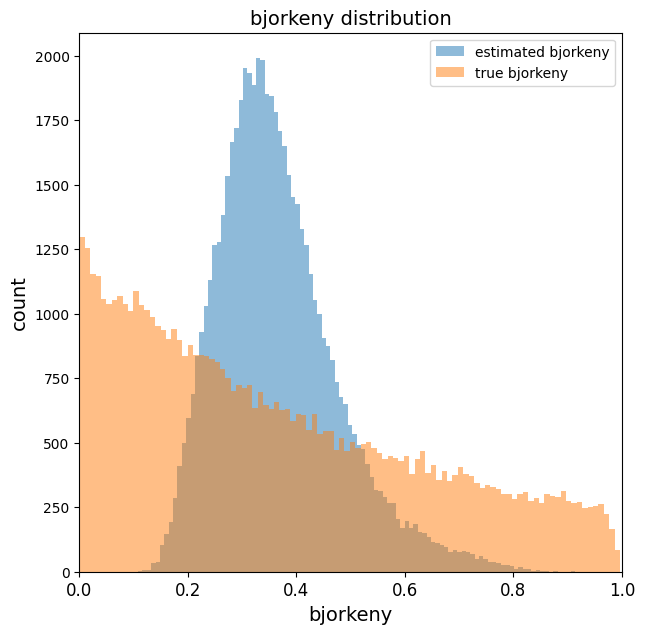

/tmp/ipykernel_13802/1764031506.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


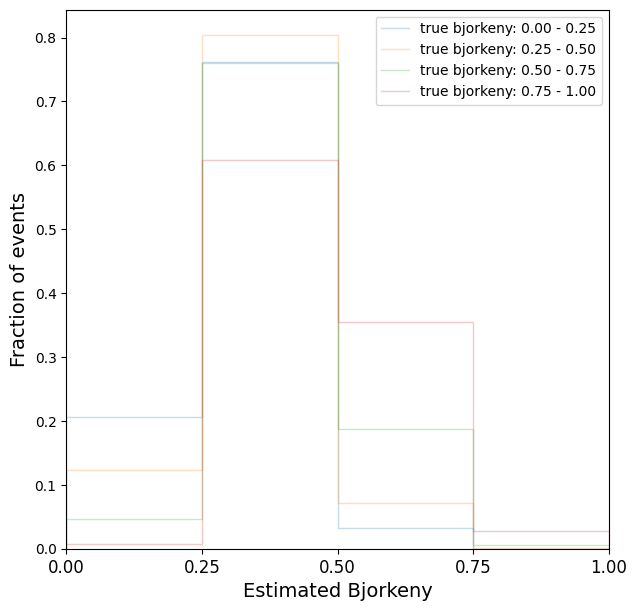

In [10]:
print(np.mean(scores), np.std(scores))
# print((y_pred_total))
# y_pred_total = np.ravel(y_pred_total)
print(np.shape(y_pred_total))
print(np.shape(y_test_total))
plt.hist(y_pred_total, bins = 100, alpha = 0.5, label = "estimated bjorkeny")
plt.hist(y_test_total, bins = 100, alpha = 0.5, label = "true bjorkeny")
plt.xlabel("bjorkeny")
plt.ylabel("count")
plt.xlim(0,1)
plt.legend()
plt.title("bjorkeny distribution")
plt.tick_params(axis='both', which='major')
plt.show()

x_axis = np.linspace(0,1,5)

true_bjorkeny_1_mask = y_test_total <= 0.25
est_bjorkeny_1_mask = y_pred_total <= 0.25

true_bjorkeny_2_mask = (y_test_total <= 0.5) & (y_test_total > 0.25)
est_bjorkeny_2_mask = (y_pred_total <= 0.5) & (y_pred_total > 0.25)

true_bjorkeny_3_mask = (y_test_total <= 0.75) & (y_test_total > 0.5)
est_bjorkeny_3_mask = (y_pred_total <= 0.75) & (y_pred_total > 0.5)

true_bjorkeny_4_mask = (y_test_total <= 1) & (y_test_total > 0.75)
est_bjorkeny_4_mask = (y_pred_total <= 1) & (y_pred_total > 0.75)

true_segments = [true_bjorkeny_1_mask, true_bjorkeny_2_mask, true_bjorkeny_3_mask, true_bjorkeny_4_mask]
est_segments = [est_bjorkeny_1_mask, est_bjorkeny_2_mask, est_bjorkeny_3_mask, est_bjorkeny_4_mask]

fig, ax = plt.subplots()
for i, segment in enumerate(true_segments):
    frac = np.sum(segment&est_segments[i])/np.sum(segment)
    fractions = [(np.sum(segment & est_segment))/np.sum(segment) for est_segment in est_segments]
    ax.stairs(fractions, x_axis, alpha = 0.25, fill = False, label = f"true bjorkeny: {x_axis[i]:.2f} - {x_axis[i+1]:.2f}")

ax.set_xticks(x_axis)
ax.set
ax.legend()
ax.set_xlim(0,1)
ax.set_xlabel("Estimated Bjorkeny")
ax.set_ylabel("Fraction of events")
fig.show()

# plt.scatter(y_test, est_bjorkeny)
# plt.xlabel("True Bjorkeny")
# plt.ylabel("Estimated Bjorkeny")
# plt.show()

# DNN

## single run

In [13]:
bjorkeny = y_full["T.sum_mc_nu.by"]

# Scale the data
scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X_full.values)

n_layers = 10
n_nodes = 256
dropout_frac = 0.1
activation_hidden = 'relu'
activation_output = 'sigmoid'
learning_rate = 0.0001

tf.keras.backend.clear_session()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(X, bjorkeny, shuffle = True, test_size=0.2, random_state=42)

# Train the DNN
DNN = tf.keras.Sequential()
DNN.add(tf.keras.layers.Input(shape=(X.shape[1],)))
# DNN.add(tf.keras.layers.Dense(64, activation="relu"))

if n_layers ==1:
    DNN.add(tf.keras.layers.Dense(n_nodes, activation=activation_hidden))
    DNN.add(keras.layers.Dropout(dropout_frac))
else: 
    for _ in range(n_layers-1):
        DNN.add(tf.keras.layers.Dense(n_nodes, activation=activation_hidden))
        DNN.add(keras.layers.Dropout(dropout_frac))

    DNN.add(tf.keras.layers.Dense(int(0.5*n_nodes), activation=activation_hidden))

    DNN.add(keras.layers.Dropout(dropout_frac))

DNN.add(tf.keras.layers.Dense(1, activation=activation_output))
DNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

history = DNN.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[callback], verbose = 0)
score = DNN.evaluate(X_test, y_test, verbose=0)


In [14]:
print("score = ", score)

score =  0.07658543437719345


mse score for base model = 0.07658543437719345

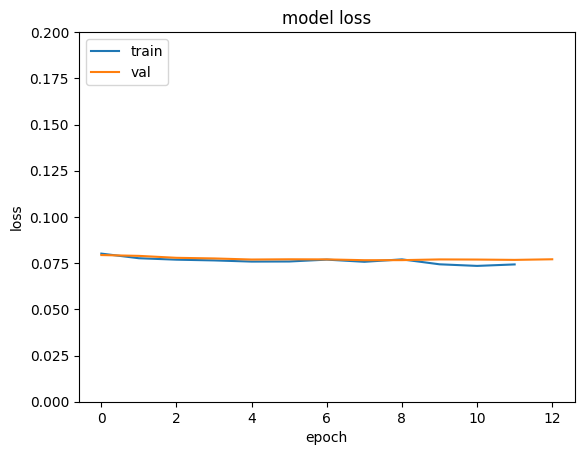

In [15]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize = font_size_title)
plt.ylabel('loss', fontsize = font_size_label)
plt.ylim(0,0.2)
plt.xlabel('epoch', fontsize = font_size_label)
plt.legend(['train', 'val'], loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=font_size_tick)
plt.show()

## CV

In [10]:
# pdgid = 14
# is_cc = 1
# # likelihood = 0.2
# nan_threshold = 0.2
# # quantile_0 = 0.2
# # quantile_1 = 0.4
# loss_metric = "mae"



# # Load data
# df_11 = pd.read_hdf("datay/new_neutrino11x_1.h5")
# df_12 = pd.read_hdf("datay/new_neutrino12x_1.h5")
# df_13 = pd.read_hdf("datay/new_neutrino13x_1.h5")

# df = pd.concat([df_11, df_12, df_13])

# # with open("bjorkeny_study_2.pkl", "rb") as f:
# #     study = pickle.load(f)

# # best_params = study.best_params
# # print(best_params)

# # Remove nans and illegitimate values
# df = remove_nans(df, nan_threshold)
# df = df[np.invert((df['closest[.,0,0]']==1e20) | (df['closest[.,1,0]']==1e20) | (df['closest[.,1,2]']==1e20) | (df['closest[.,0,1]']==1e20)  )] 

# # select the particle and interaction types
# df = df[(df["pdgid"]==pdgid)&(df["is_cc"]==is_cc)]

# # select based on energy
# df = df[(df["E.trks.E[.,0]"]<=20) | (df["E.trks.E[.,1]"]<=20)]

# # remove unneeded columns
# df = df.drop(columns = ["exposure", "weight", "weight_rate", "E.run_id", "pdgid", "is_cc", "energy"])

# # select based on likelihood

# # q0 = np.quantile(df["E.trks.lik[.,0]"], quantile_0)
# # q1 = np.quantile(df["E.trks.lik[.,1]"], 1-quantile_1)
# # df = df[(df["E.trks.lik[.,0]"]>q0) | (df["E.trks.lik[.,1]"] < q1)]

# # corr = df.corr()
# # bjorkeny_corr = corr['T.sum_mc_nu.by']
# # correlation_threshold = best_params["correlation_threshold"]
# # non_rel = bjorkeny_corr.index[abs(bjorkeny_corr)<=correlation_threshold]

# # df = df.drop(columns = non_rel)

random_state = 42

bjorkeny = y_full["T.sum_mc_nu.by"].values

# Scale the data
X = X_full.values
scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X)

# # PCA
n_components_PCA = 0.9

pca = PCA(n_components=n_components_PCA, svd_solver="full")
X = pca.fit_transform(X)

# Split the data into folds
kfold = KFold(n_splits=5, shuffle=False)

n_layers = 10
n_nodes = 256
dropout_frac = 0.1
activation_hidden = 'relu'
activation_output = 'sigmoid'
learning_rate = 0.0001

scores = []

y_pred_total = []
y_test_total = []



for train_index, test_index in kfold.split(X):

    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = bjorkeny[train_index], bjorkeny[test_index]

    # Train the DNN
    DNN = tf.keras.Sequential()
    DNN.add(tf.keras.layers.Input(shape=(X.shape[1],)))
    # DNN.add(tf.keras.layers.Dense(64, activation="relu"))

    if n_layers ==1:
        DNN.add(tf.keras.layers.Dense(n_nodes, activation=activation_hidden))
        DNN.add(keras.layers.Dropout(dropout_frac))
    else: 
        for _ in range(n_layers-1):
            DNN.add(tf.keras.layers.Dense(n_nodes, activation=activation_hidden))
            DNN.add(keras.layers.Dropout(dropout_frac))

        DNN.add(tf.keras.layers.Dense(int(0.5*n_nodes), activation=activation_hidden))

        DNN.add(keras.layers.Dropout(dropout_frac))

    DNN.add(tf.keras.layers.Dense(1, activation=activation_output))
    DNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    DNN.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test_total), callbacks=[callback], verbose = 0)
    score = DNN.evaluate(X_test, y_test_total, verbose=0)
    y_pred = DNN.predict(X_test)
    y_pred_total.extend(y_pred)
    y_test_total.extend(y_test)
    scores.append(score)

keras.backend.clear_session()
print(np.mean(scores))

y_pred_total = np.array(y_pred_total).reshape(-1,1)
y_test_total = np.array(y_test_total).reshape(-1,1)

ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

In [ ]:
y_pred_total = np.ravel(y_pred_total)
y_test_total = np.ravel(y_test_total)



0.1769021511077881 0.007147834641465949
(6746,)
(6746,)


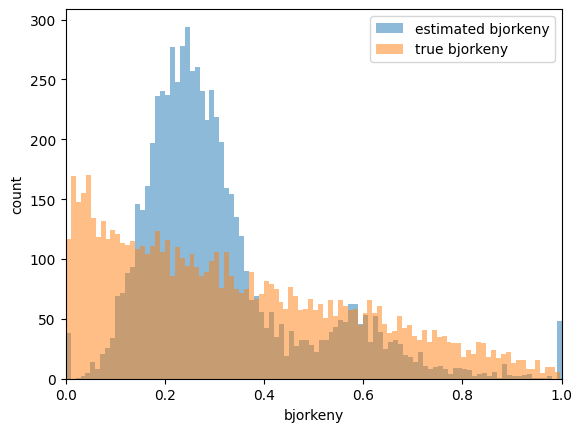

/tmp/ipykernel_62957/3820185998.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


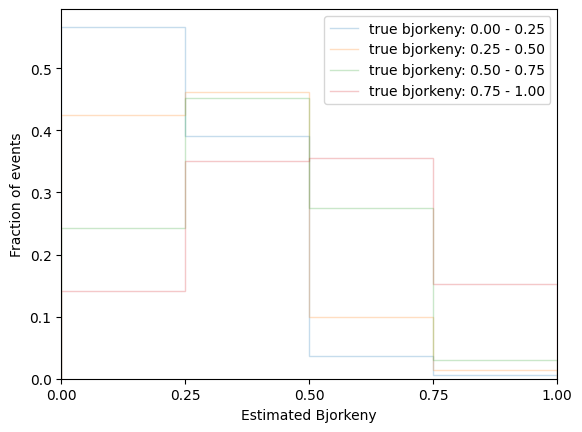

In [ ]:
print(np.mean(scores), np.std(scores))
# print((y_pred_total))
# y_pred_total = np.ravel(y_pred_total)
print(np.shape(y_pred_total))
print(np.shape(y_test_total))
plt.hist(y_pred_total, bins = 100, alpha = 0.5, label = "estimated bjorkeny")
plt.hist(y_test_total, bins = 100, alpha = 0.5, label = "true bjorkeny")
plt.xlabel("bjorkeny", fontsize = font_size_label)
plt.ylabel("count", fontsize = font_size_label)
plt.xlim(0,1)
plt.legend()
plt.title("bjorkeny distribution", fontsize = font_size_title)
plt.tick_params(axis='both', which='major', labelsize=font_size_tick)
plt.show()

x_axis = np.linspace(0,1,5)

true_bjorkeny_1_mask = y_test_total <= 0.25
est_bjorkeny_1_mask = y_pred_total <= 0.25

true_bjorkeny_2_mask = (y_test_total <= 0.5) & (y_test_total > 0.25)
est_bjorkeny_2_mask = (y_pred_total <= 0.5) & (y_pred_total > 0.25)

true_bjorkeny_3_mask = (y_test_total <= 0.75) & (y_test_total > 0.5)
est_bjorkeny_3_mask = (y_pred_total <= 0.75) & (y_pred_total > 0.5)

true_bjorkeny_4_mask = (y_test_total <= 1) & (y_test_total > 0.75)
est_bjorkeny_4_mask = (y_pred_total <= 1) & (y_pred_total > 0.75)

true_segments = [true_bjorkeny_1_mask, true_bjorkeny_2_mask, true_bjorkeny_3_mask, true_bjorkeny_4_mask]
est_segments = [est_bjorkeny_1_mask, est_bjorkeny_2_mask, est_bjorkeny_3_mask, est_bjorkeny_4_mask]

fig, ax = plt.subplots()
for i, segment in enumerate(true_segments):
    frac = np.sum(segment&est_segments[i])/np.sum(segment)
    fractions = [(np.sum(segment & est_segment))/np.sum(segment) for est_segment in est_segments]
    ax.stairs(fractions, x_axis, alpha = 0.25, fill = False, label = f"true bjorkeny: {x_axis[i]:.2f} - {x_axis[i+1]:.2f}")

ax.set_xticks(x_axis)
ax.set
ax.legend()
ax.set_xlim(0,1)
ax.set_xlabel("Estimated Bjorkeny")
ax.set_ylabel("Fraction of events")
fig.show()

# plt.scatter(y_test, est_bjorkeny)
# plt.xlabel("True Bjorkeny")
# plt.ylabel("Estimated Bjorkeny")
# plt.show()

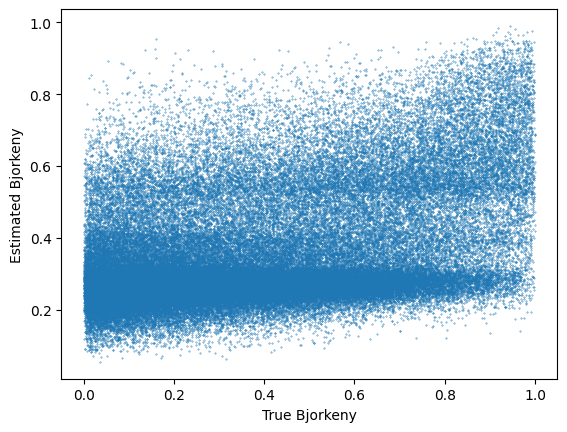

In [12]:
plt.scatter(y_test_total, y_pred_total, s=0.1)
plt.xlabel("True Bjorkeny")
plt.ylabel("Estimated Bjorkeny")
plt.show()

## analyze the two different distributions in the data

length of test data is  111991
the corresponding is  111991


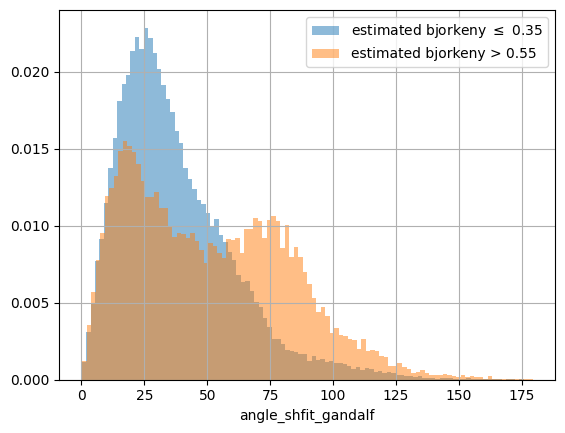

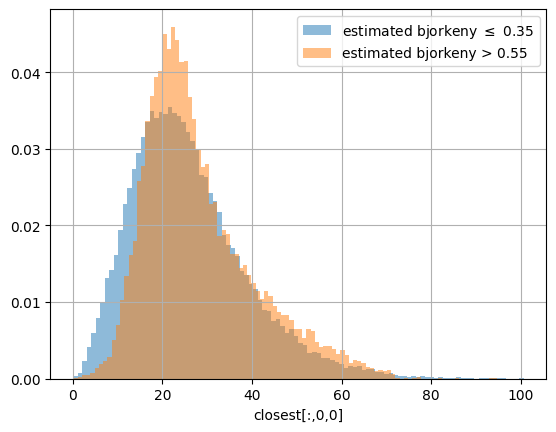

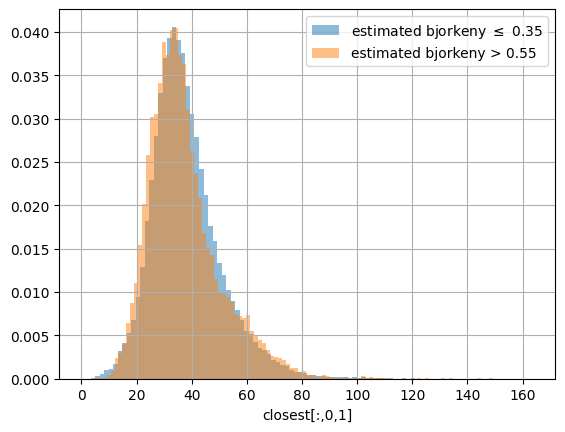

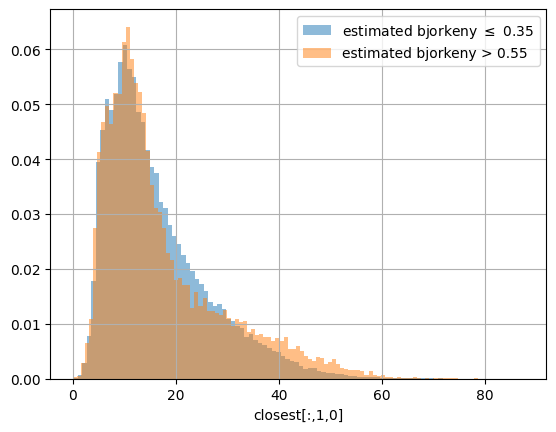

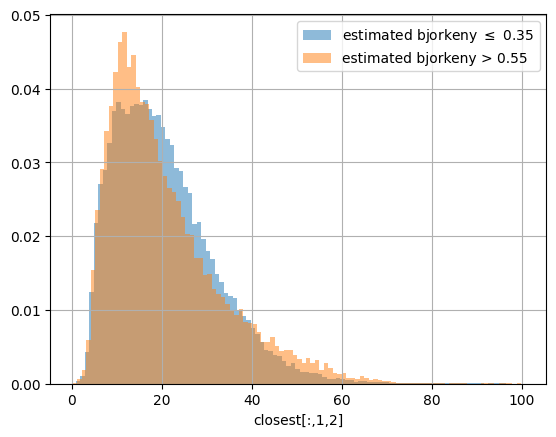

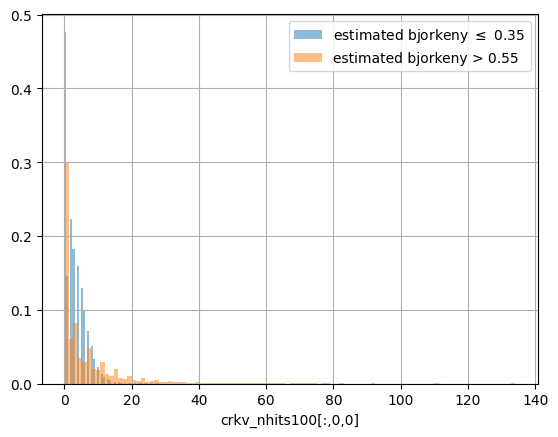

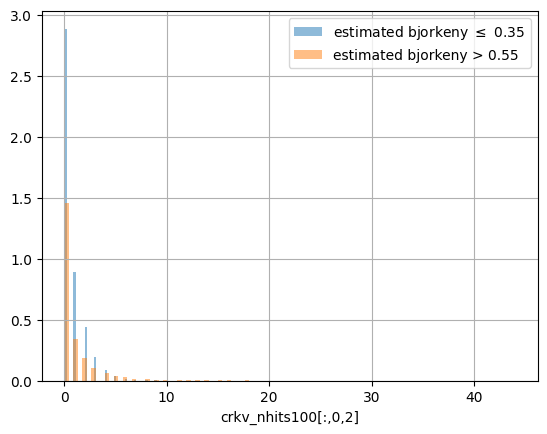

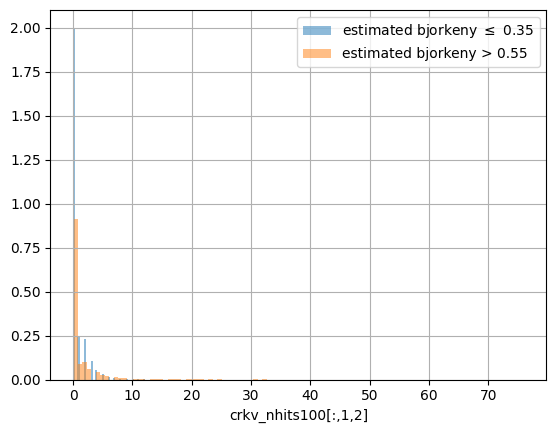

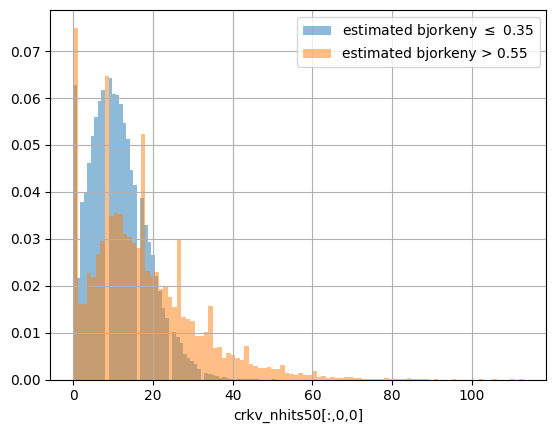

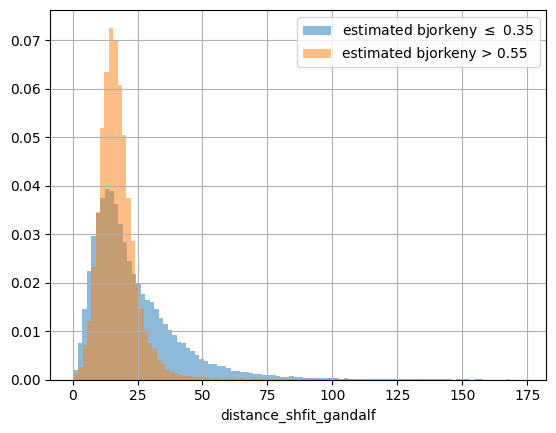

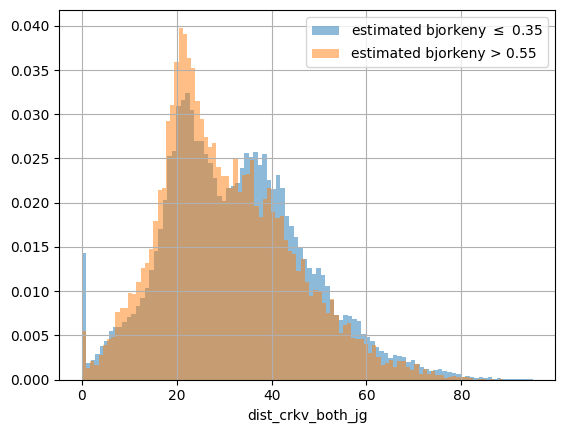

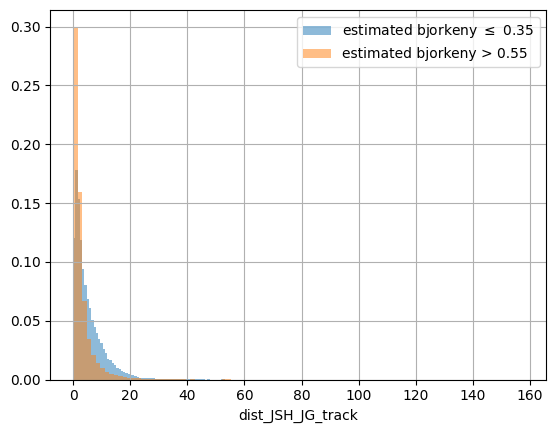

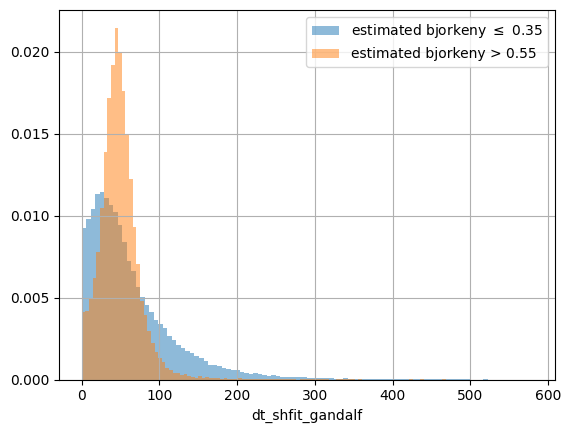

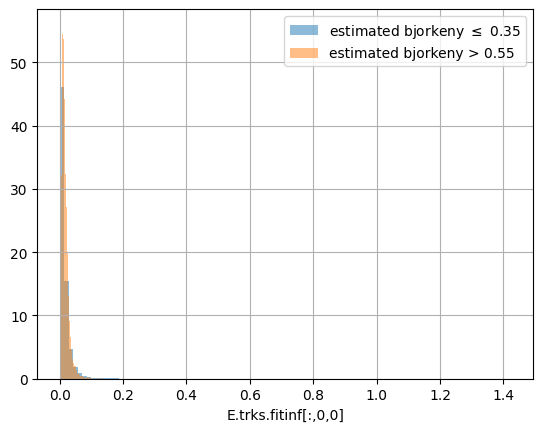

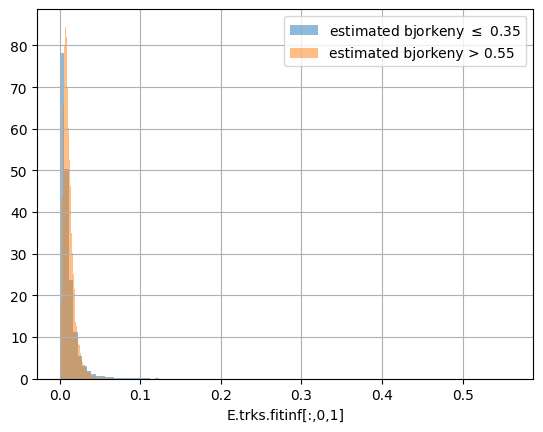

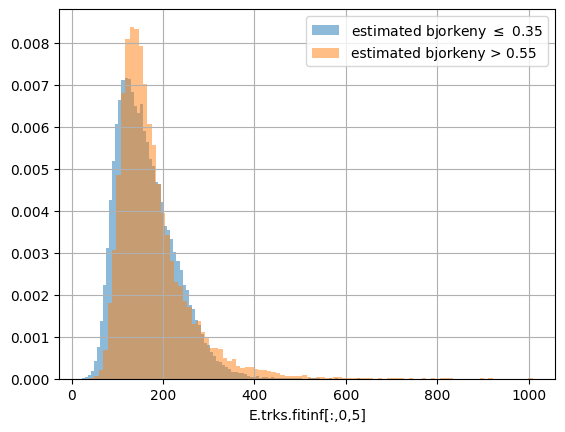

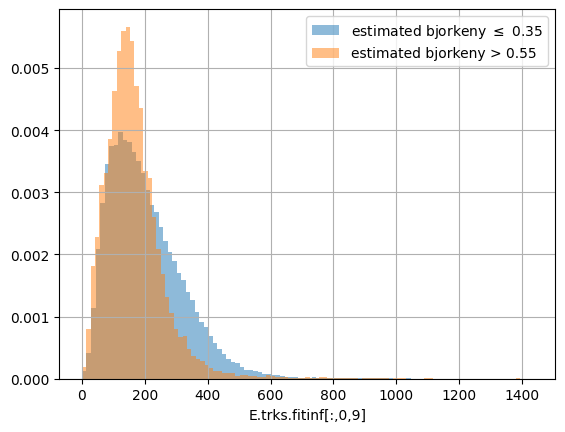

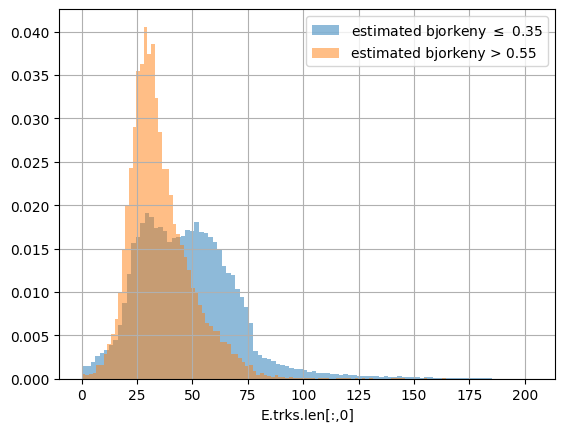

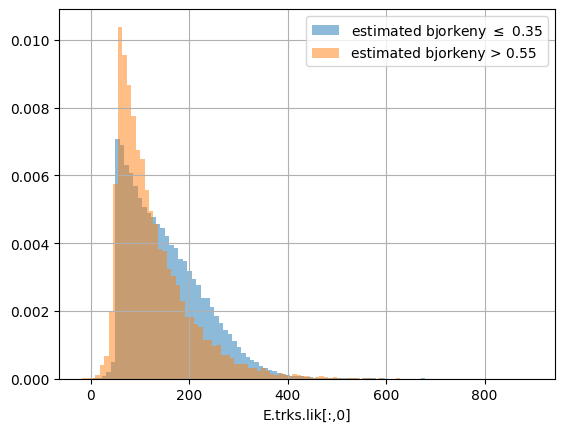

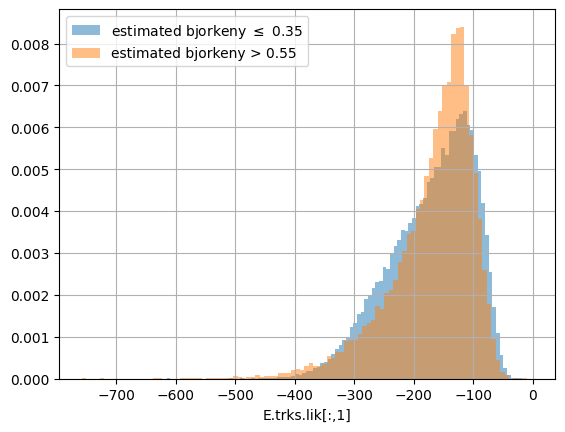

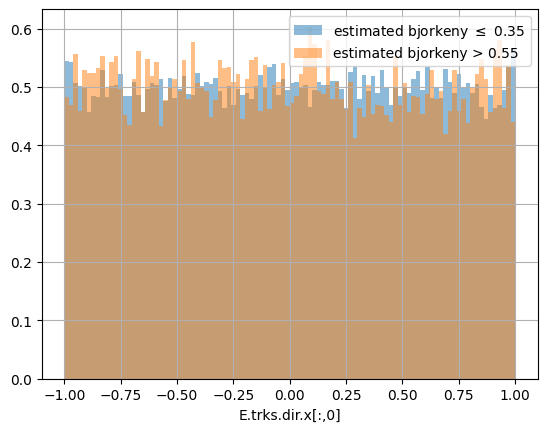

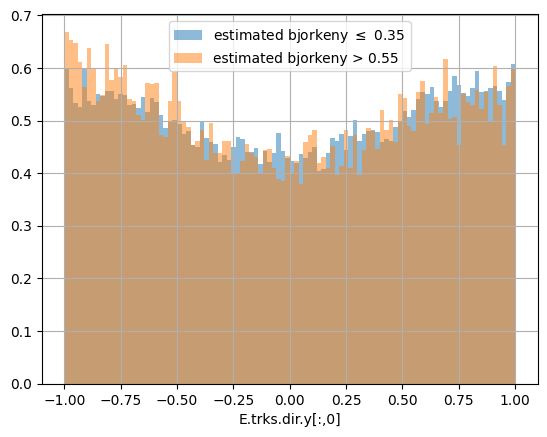

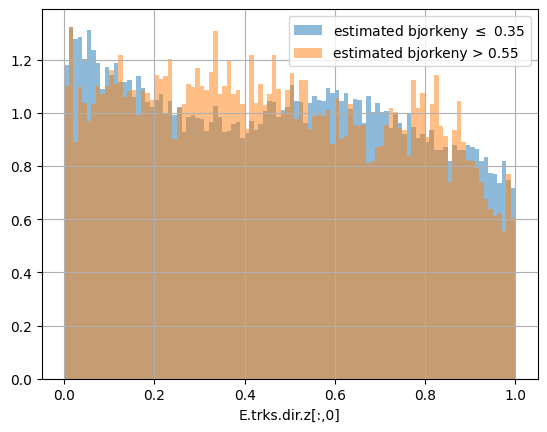

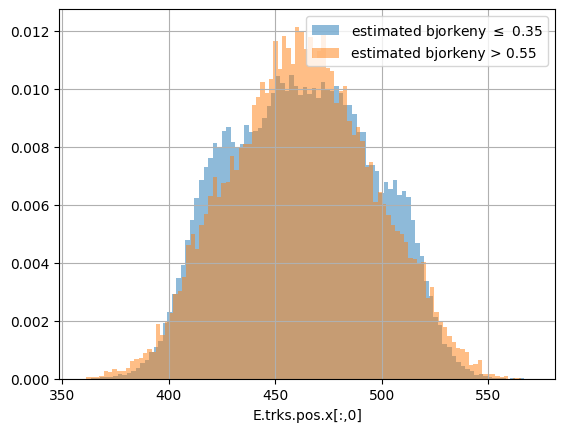

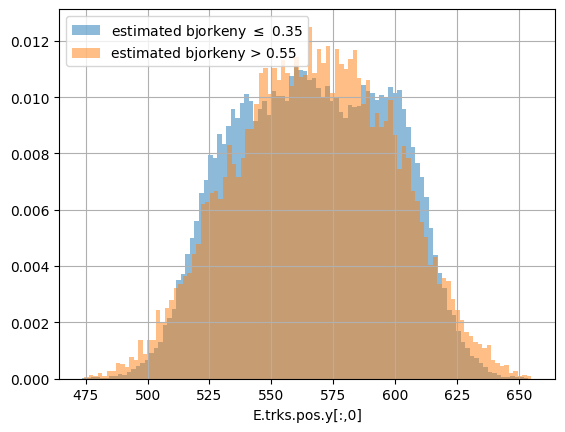

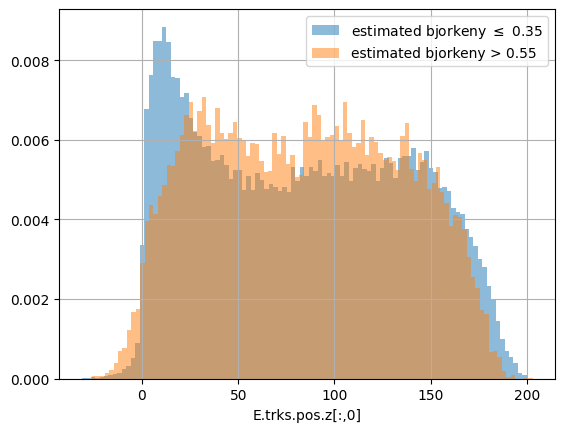

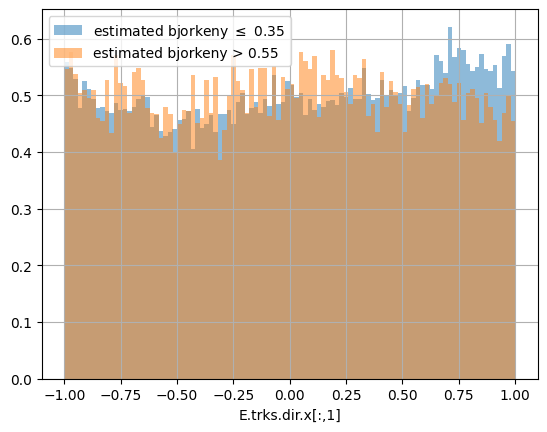

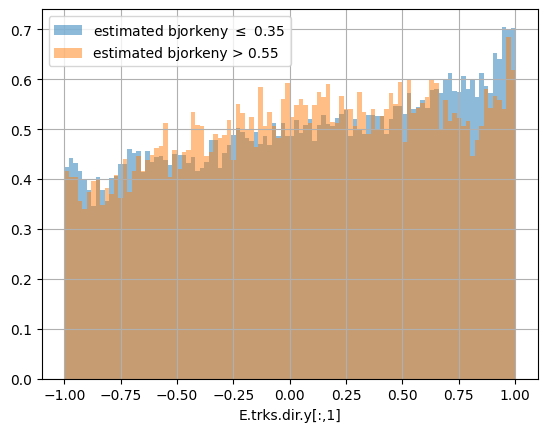

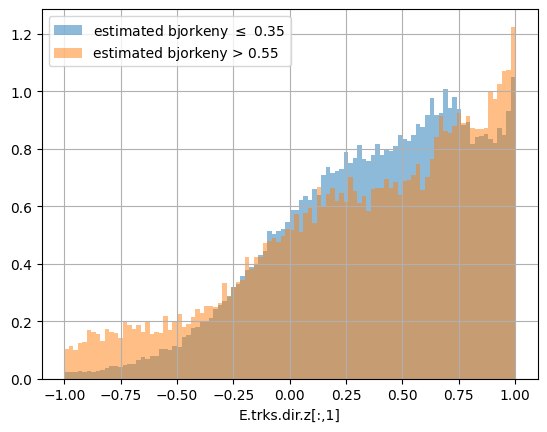

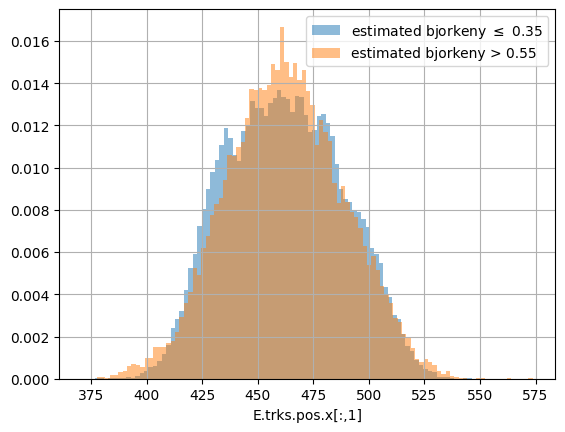

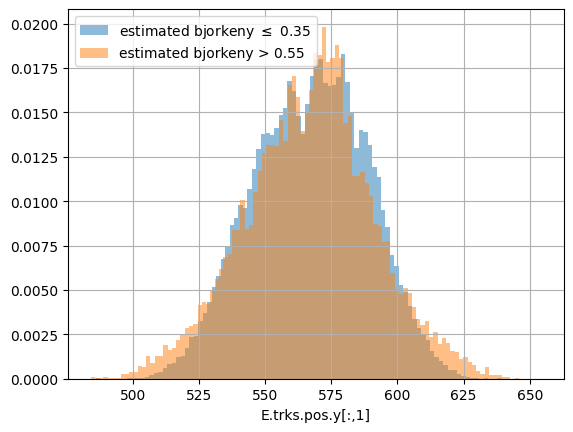

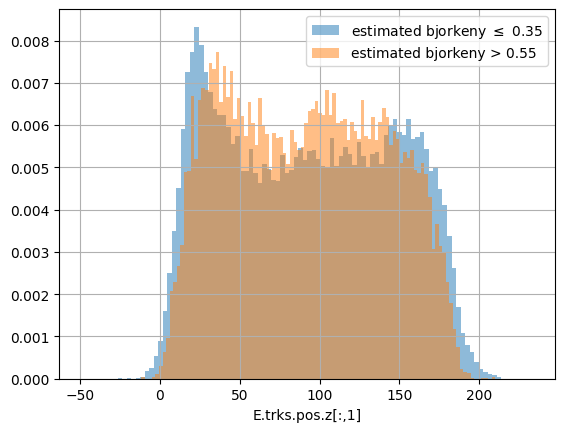

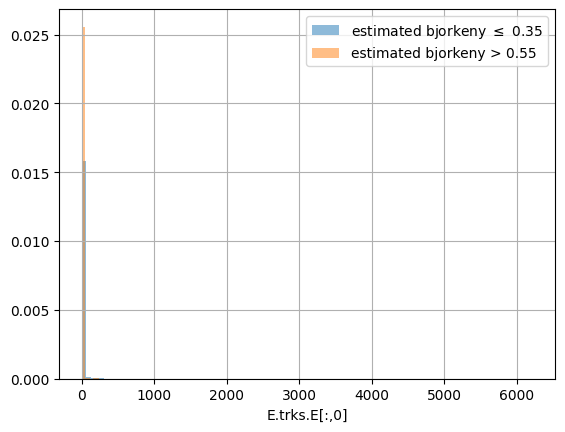

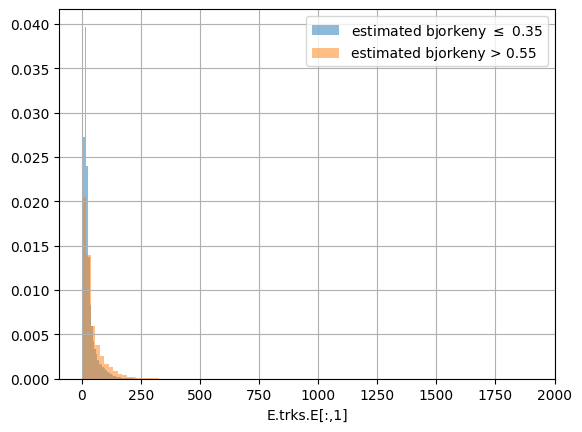

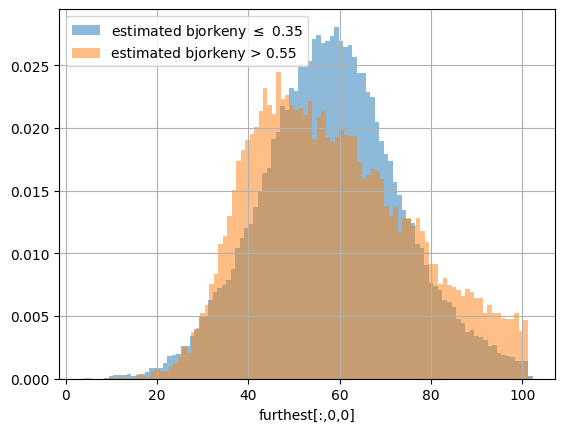

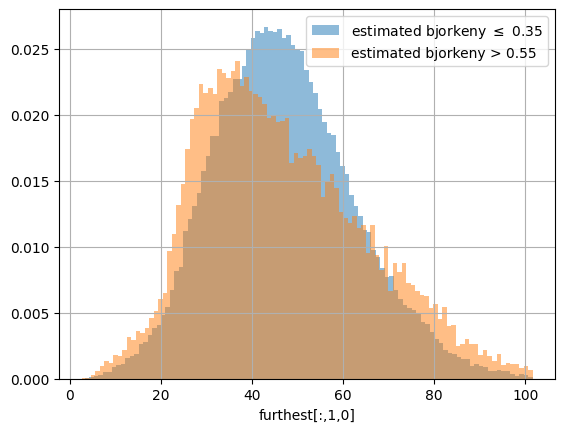

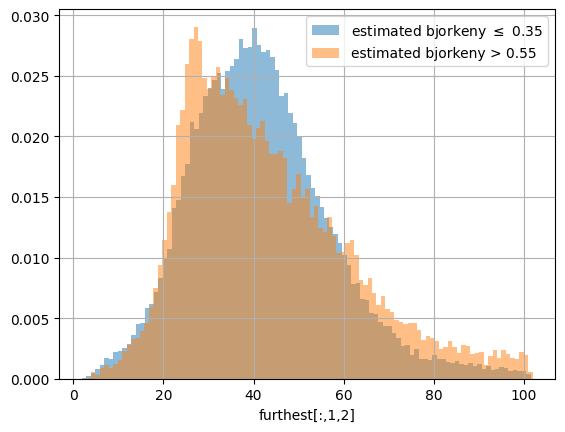

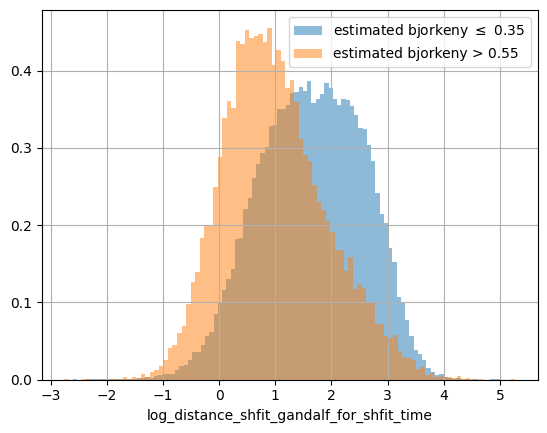

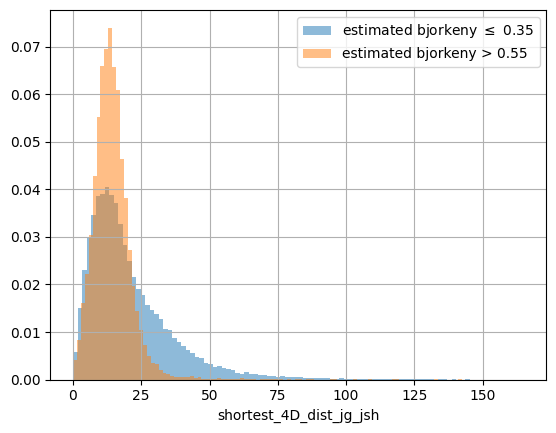

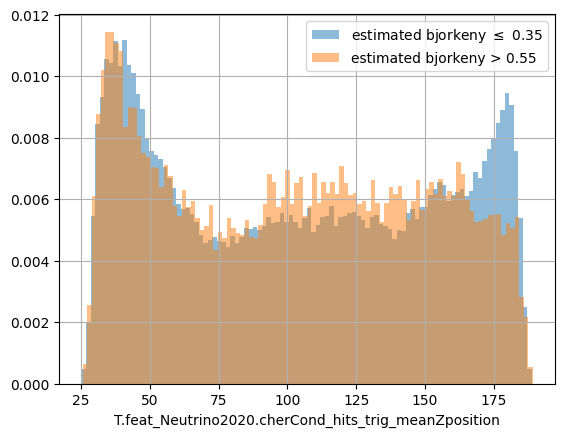

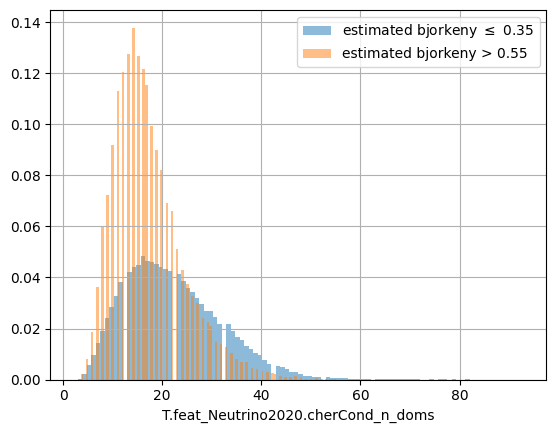

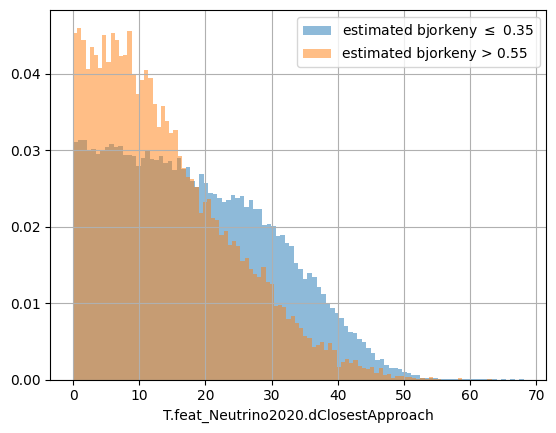

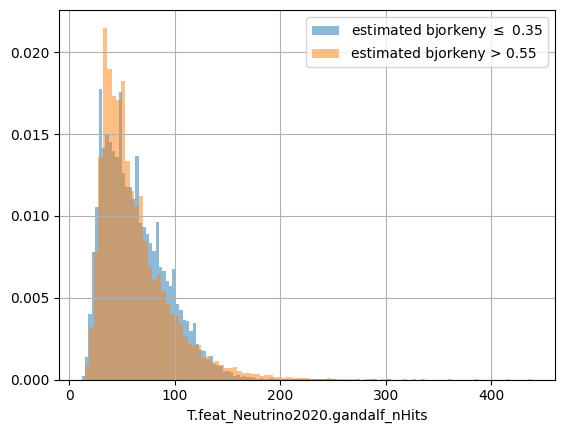

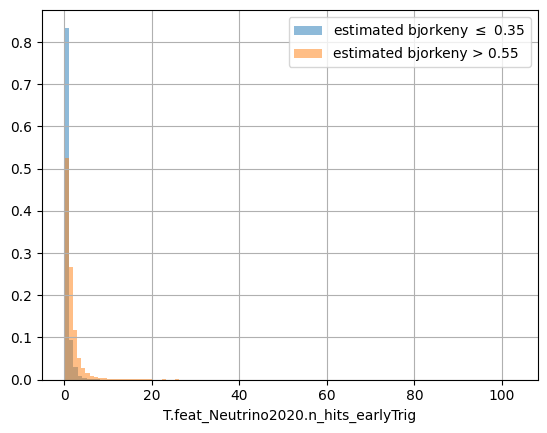

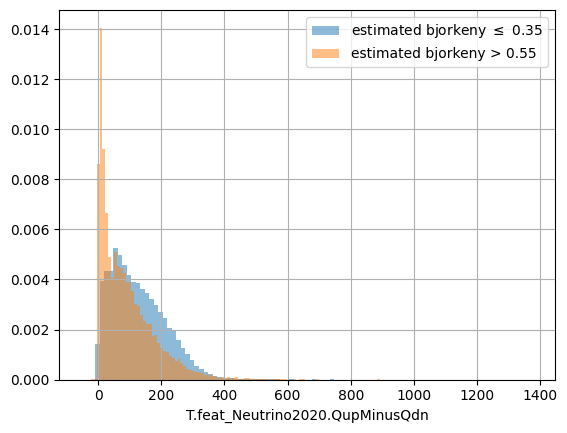

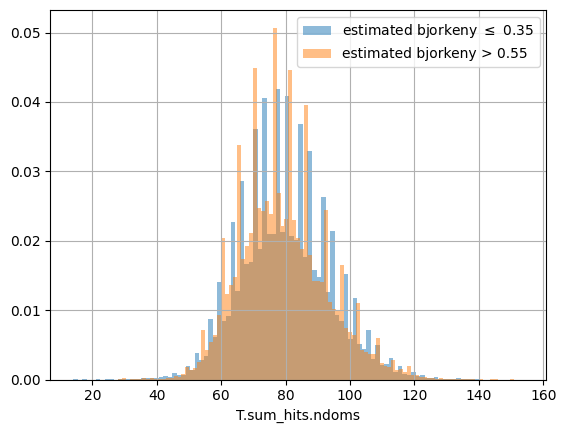

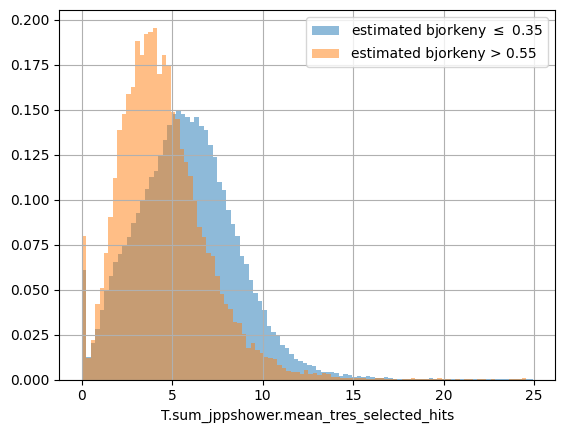

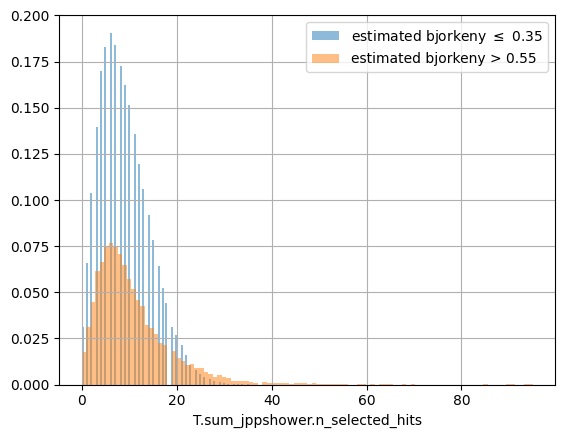

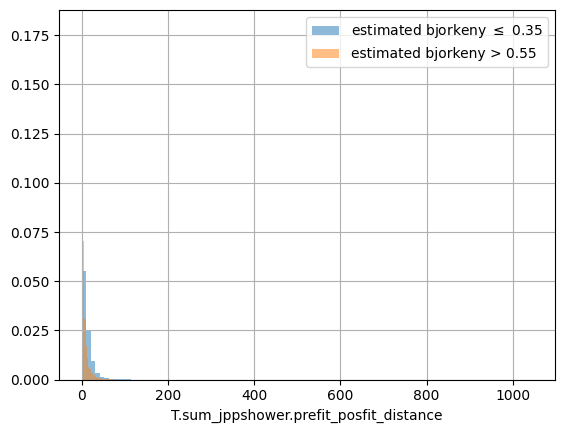

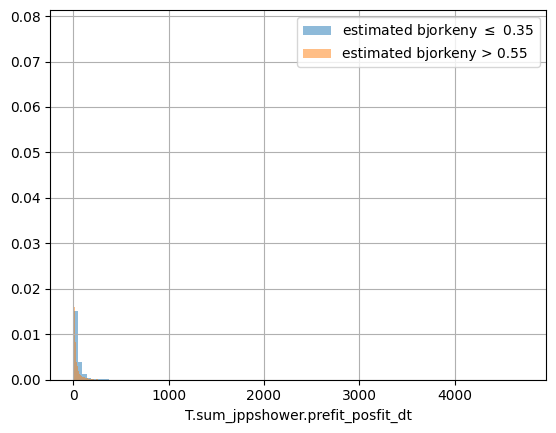

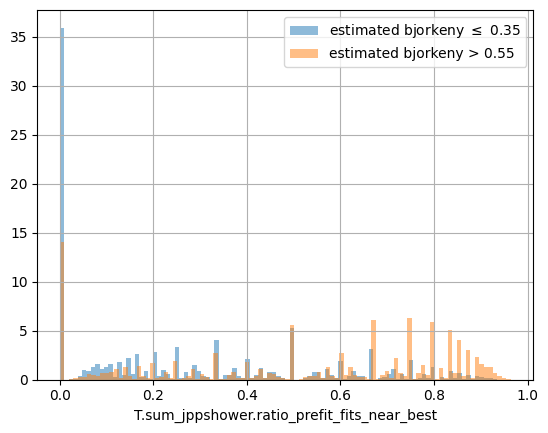

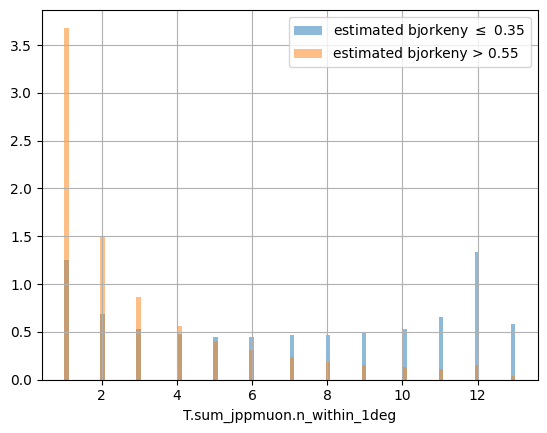

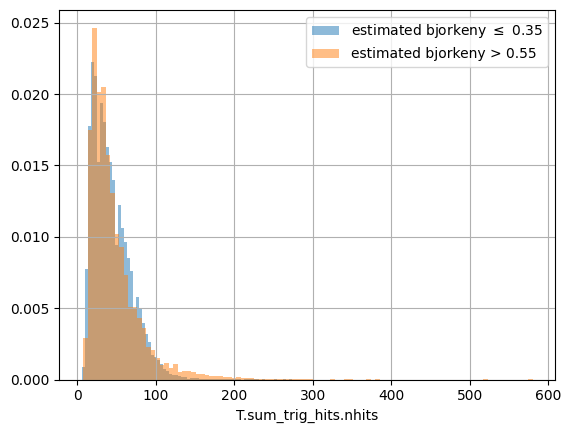

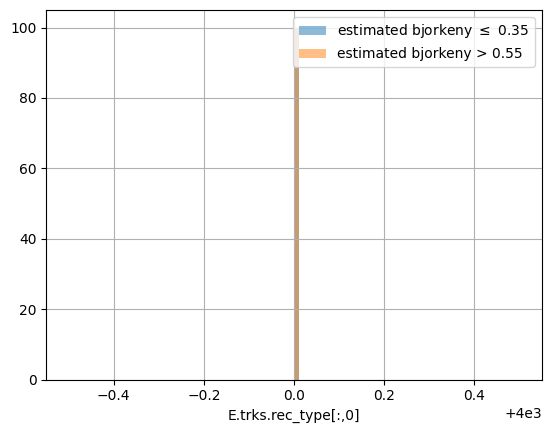

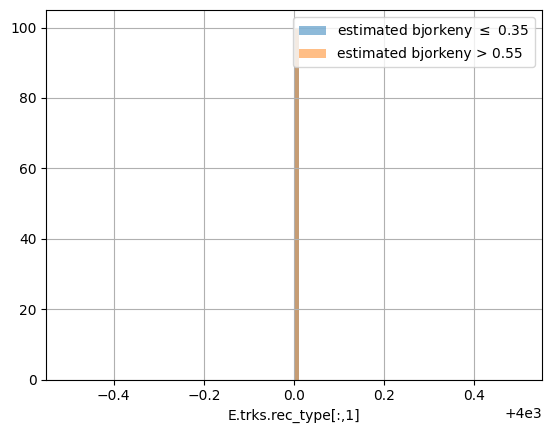

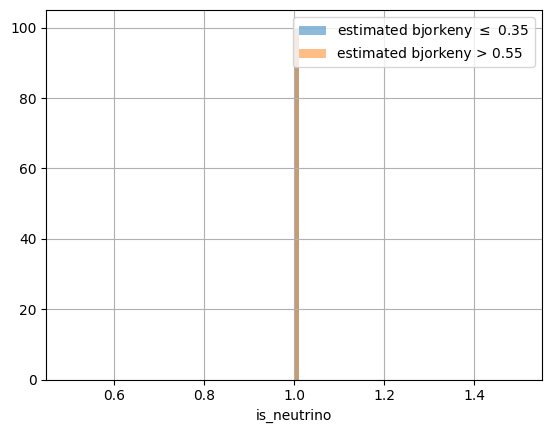

In [14]:
# first check if the data indexing matches
print("length of test data is ", len(y_test_total))
print("the corresponding is ", np.sum(y_test_total == bjorkeny))

X_dist_1 = df_X[y_pred_total <= 0.35]
X_dist_2 = df_X[y_pred_total > 0.50]

for column in df_X.columns:
    hist_1 = X_dist_1[column].hist(bins = 100, alpha = 0.5, label = "estimated bjorkeny $\leq$ 0.35", density = True)
    hist_2 = X_dist_2[column].hist(bins = 100, alpha = 0.5, label = "estimated bjorkeny > 0.55", density = True)
    plt.xlabel(column)
    plt.legend()
    plt.show()

In [4]:
random_state = 42 
# n_estimators = 100
# criterion = "squared_error"
# min_samples_split = 2
# max_samples = 0.5
# max_features = "auto"

# result = permutation_importance(clf, X, y, n_repeats=10, random_state=random_state, n_jobs=-1)


kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)


X_selected_features = X_full.copy()
exp_data = pd.DataFrame()

feature_importances_total = np.zeros(len(X_selected_features.columns))


for train_index, test_index in kfold.split(X_selected_features):

    X_train, X_test = X_selected_features.iloc[train_index].copy(), X_selected_features.iloc[test_index].copy()
    y_train_compl, y_test_compl = y_full.iloc[train_index].copy(), y_full.iloc[test_index].copy()

    y_train = y_train_compl["T.sum_mc_nu.by"]

    regr = RFR(random_state=random_state,  verbose = 0, n_jobs=-1)   
  
    regr.fit(X_train, y_train)
    feature_importances_total += regr.feature_importances_  
    y_pred = regr.predict(X_test)
    y_test_compl['prediction'] = y_pred

    exp_data = pd.concat([exp_data, y_test_compl])

    
feature_importances_total = feature_importances_total/5

print("mse = {}".format(np.mean(np.square(exp_data["prediction"]-exp_data["T.sum_mc_nu.by"]))))


    

mse = 0.05559538717946061


mse for base model was: 0.05559538717946061

Feature ranking:
1. feature T.sum_jppshower.prefit_posfit_distance (0.037915)
2. feature gandalf_shfit_lik_ratio (0.028620)
3. feature E.trks.fitinf[:,0,5] (0.028572)
4. feature RGS_track_tau (0.022123)
5. feature crkv_nhits50[:,0,0] (0.020021)
6. feature angle_shfit_gandalf (0.018925)
7. feature T.feat_Neutrino2020.QupOvernHits (0.018615)
8. feature ratio_both_tot_jg (0.017532)
9. feature T.sum_jpptrack.n_within_1deg (0.017132)
10. feature T.sum_jppshower.ratio_prefit_fits_near_best (0.016258)
11. feature dt_shfit_gandalf (0.016168)
12. feature ratio_E_jshf_gandalf (0.015001)
13. feature E.trks.fitinf[:,0,9] (0.014681)
14. feature E.trks.E[:,1] (0.014525)
15. feature closest[:,0,0] (0.014242)
16. feature T.sum_jppshower.mean_tres_selected_hits (0.013874)
17. feature log_distance_shfit_gandalf_for_shfit_time (0.012814)
18. feature T.feat_Neutrino2020.dClosestApproach (0.012686)
19. feature closest[:,1,2] (0.012478)
20. feature ratio_both_tot_jsh (0.012475)
21. feature T.sum_jppshower.p

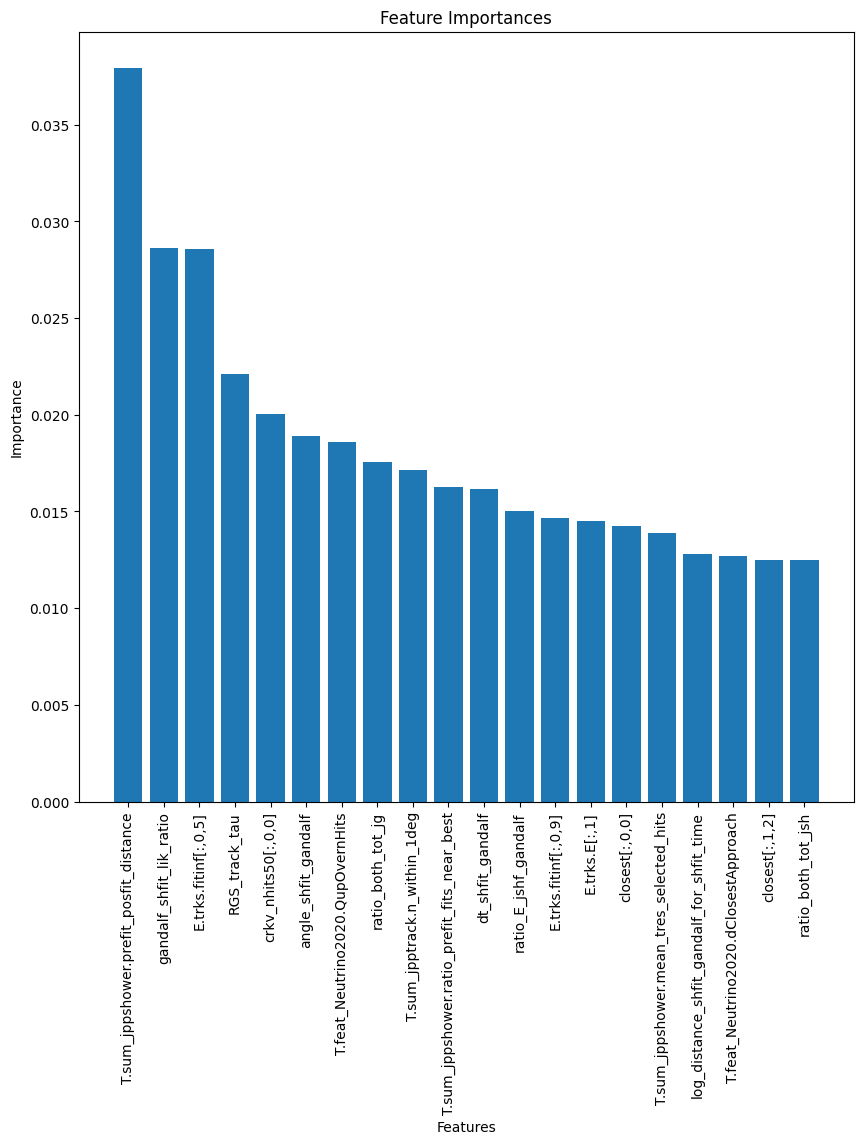

In [7]:
indices = np.argsort(feature_importances_total)[::-1]
print("Feature ranking:")
for f in range(X_full.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_full.columns[indices[f]], feature_importances_total[indices[f]]))

# print oob error
plt.figure(figsize=(10, 10))
plt.bar(range(20), feature_importances_total[indices[:20]], align='center')
plt.xticks(range(20), X_full.columns[indices[:20]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

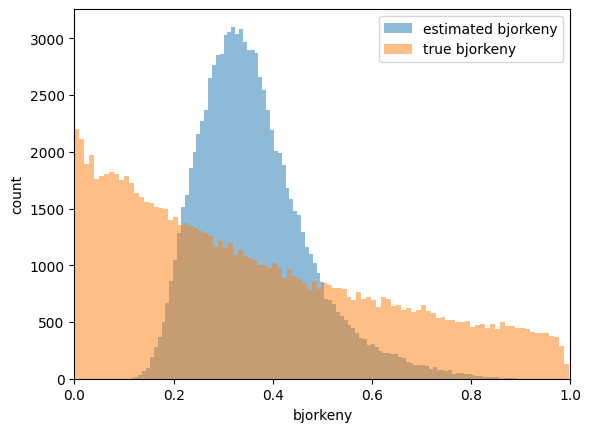

/tmp/ipykernel_111528/2764990246.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


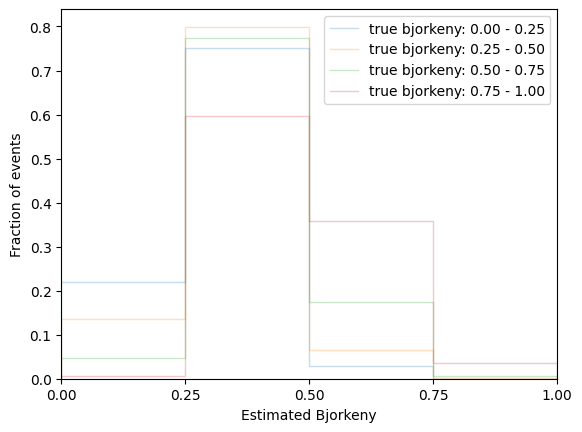

In [8]:
y_test_total = exp_data["T.sum_mc_nu.by"]
y_pred_total = exp_data["prediction"]
plt.hist(y_pred_total, bins = 100, alpha = 0.5, label = "estimated bjorkeny")
plt.hist(y_test_total, bins = 100, alpha = 0.5, label = "true bjorkeny")
plt.xlabel("bjorkeny")
plt.ylabel("count")
plt.xlim(0,1)
plt.legend()
plt.show()

x_axis = np.linspace(0,1,5)

true_bjorkeny_1_mask = y_test_total <= 0.25
est_bjorkeny_1_mask = y_pred_total <= 0.25

true_bjorkeny_2_mask = (y_test_total <= 0.5) & (y_test_total > 0.25)
est_bjorkeny_2_mask = (y_pred_total <= 0.5) & (y_pred_total > 0.25)

true_bjorkeny_3_mask = (y_test_total <= 0.75) & (y_test_total > 0.5)
est_bjorkeny_3_mask = (y_pred_total <= 0.75) & (y_pred_total > 0.5)

true_bjorkeny_4_mask = (y_test_total <= 1) & (y_test_total > 0.75)
est_bjorkeny_4_mask = (y_pred_total <= 1) & (y_pred_total > 0.75)

true_segments = [true_bjorkeny_1_mask, true_bjorkeny_2_mask, true_bjorkeny_3_mask, true_bjorkeny_4_mask]
est_segments = [est_bjorkeny_1_mask, est_bjorkeny_2_mask, est_bjorkeny_3_mask, est_bjorkeny_4_mask]

fig, ax = plt.subplots()
for i, segment in enumerate(true_segments):
    frac = np.sum(segment&est_segments[i])/np.sum(segment)
    fractions = [(np.sum(segment & est_segment))/np.sum(segment) for est_segment in est_segments]
    ax.stairs(fractions, x_axis, alpha = 0.25, fill = False, label = f"true bjorkeny: {x_axis[i]:.2f} - {x_axis[i+1]:.2f}")

ax.set_xticks(x_axis)
ax.legend()
ax.set_xlim(0,1)
ax.set_xlabel("Estimated Bjorkeny")
ax.set_ylabel("Fraction of events")
fig.show()

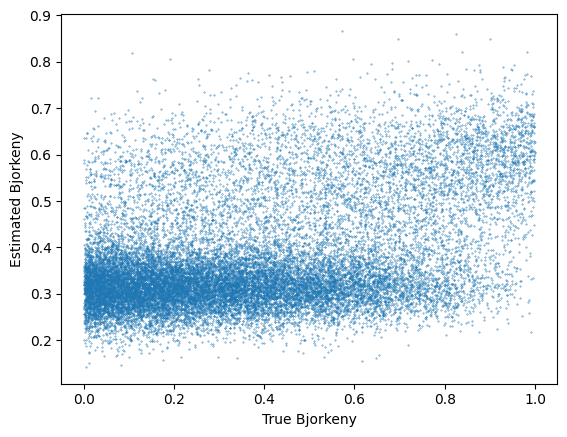

In [11]:
plt.scatter(y_test_total, y_pred_total, s=0.1)
plt.xlabel("True Bjorkeny")
plt.ylabel("Estimated Bjorkeny")
plt.show()

# Try RDF classification into the 4 categories

In [12]:
y=bjorkeny
first = y <= 0.25
second = (y > 0.25) & (y <= 0.5)
third = (y > 0.5) & (y <= 0.75)
fourth = y > 0.75

y_labels = y.copy()
y_labels[first] = 0
y_labels[second] = 1
y_labels[third] = 2
y_labels[fourth] = 3


In [13]:
X_train, X_test, y_train, y_test_total = train_test_split(X, y_labels , shuffle = True, test_size=0.2, random_state=42)

In [14]:
n_estimators = 101
regr = RFC(n_estimators=n_estimators, random_state=42, n_jobs=-1, verbose = 1, class_weight='balanced')
regr.fit(X_train, y_train)
y_pred_total = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.3s finished


In [15]:
print(regr.score(X_test, y_test_total))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


0.432297400287916


[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.3s finished


In [16]:
for segment in range(4):
    print(f"segment {segment}")
    estimates = y_pred_total[y_test_total == segment]
    counter = Counter(estimates)
    perc = {key: value/len(estimates) for key, value in counter.items()}
    print(perc)



segment 0
{0.0: 0.8373723832113025, 1.0: 0.09704032174899453, 2.0: 0.03196865009796845, 3.0: 0.033618644941734555}
segment 1
{0.0: 0.7759595358524248, 3.0: 0.06962213626896757, 2.0: 0.05534067241892294, 1.0: 0.09907765545968462}
segment 2
{0.0: 0.6513961605584643, 1.0: 0.11387434554973822, 3.0: 0.13721640488656195, 2.0: 0.0975130890052356}
segment 3
{0.0: 0.3403441682600382, 1.0: 0.10975143403441683, 3.0: 0.37361376673040153, 2.0: 0.17629063097514341}


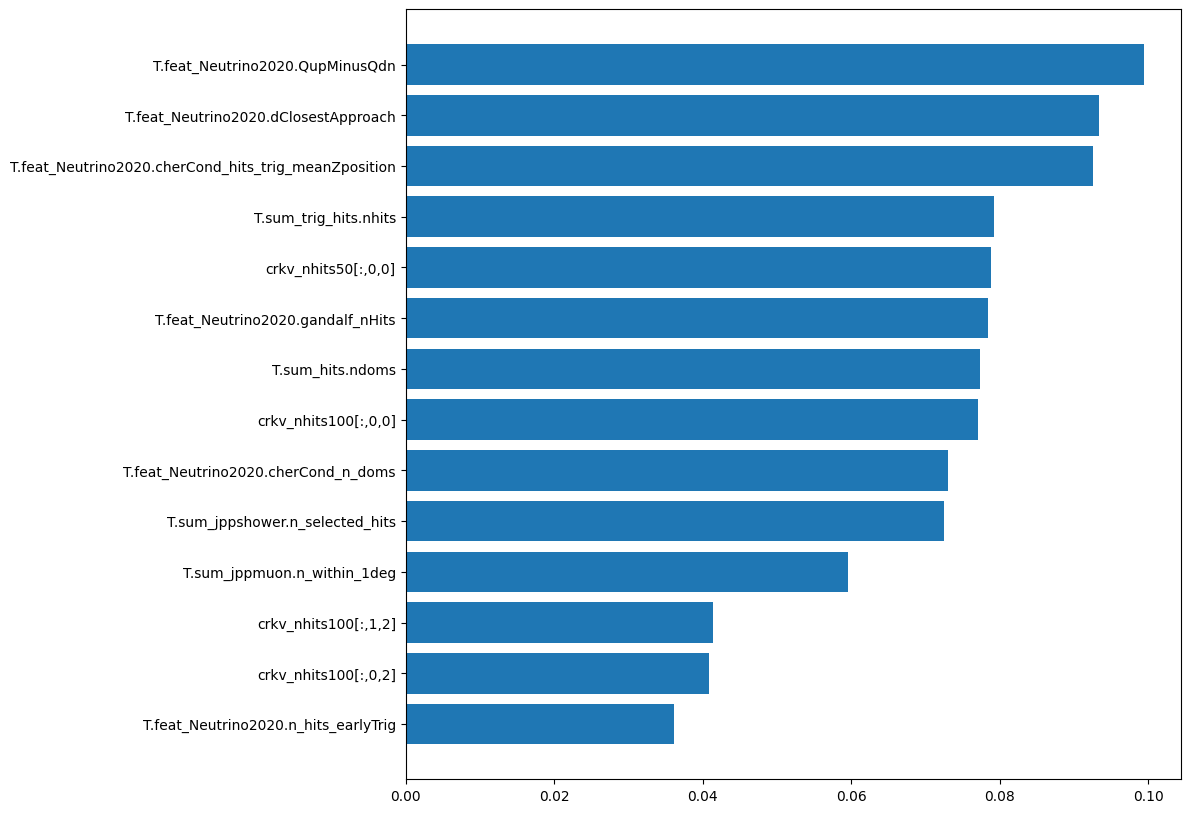

<class 'pandas.core.frame.DataFrame'>
Index: 118088 entries, 1098 to 235605
Data columns (total 14 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   crkv_nhits100[:,0,0]                                  118088 non-null  int32  
 1   crkv_nhits100[:,0,2]                                  118088 non-null  int32  
 2   crkv_nhits100[:,1,2]                                  118088 non-null  int32  
 3   crkv_nhits50[:,0,0]                                   118088 non-null  int32  
 4   T.feat_Neutrino2020.cherCond_hits_trig_meanZposition  118088 non-null  float32
 5   T.feat_Neutrino2020.cherCond_n_doms                   118088 non-null  int32  
 6   T.feat_Neutrino2020.dClosestApproach                  118088 non-null  float32
 7   T.feat_Neutrino2020.gandalf_nHits                     118088 non-null  int32  
 8   T.feat_Neutrino2020.n_hits_earlyTrig          

In [17]:
feature_importances = regr.feature_importances_
n_its = 1
plt.figure(figsize=(10,10))
f_i = list(zip(X_train.columns , feature_importances/n_its))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

print(X.info())